# PA005: High Value Customer Identification (Insiders)

## 0.0. Planejamento da Solução (IOT)


### Input - Entrada

1. Problema de Negócio
    * Selecionar os clientes mais valioses para integrar um programa de Fidelização
2. Conjunto de Dados
    * Vendas de um e-commerce online, dutante o período de um ano.

### Output - Saída

1. A indicação das pessoas que farão parte do programa de Insiders
    - Lista: 
| client_id | is_insider |
|-----------|------------|
|    10323   |   yes/1    |
|    32413   |   no/1    |

2. Relatório com as perguntas de negócio
    * Quem são as pessoas elegíveis para participar do programa de Insiders?
    * Quantos clientes farão parte do grupo?
    * Quais as principais características desses clientes?
    * Qual a porcentagem de contribuição do faturamento, vinda do Insiders?
    * Qual a expectativa de faturamento desse grupo para os próximos meses?
    * Quais as condições para uma pessoa ser elegível ao Insiders?
    * Quais as condições para uma pessoa ser removida do Insiders?
    * Qual a garantia que o programa Insiders é melhor que o restante da base?
    * Quais ações o time de marketing pode realizar para aumentar o faturamento?

1. Quem são as pessoas elegíveis para participar do programa de Insiders?
    - O que é ser elegível? O que são clientes de maior "valor"?
    - Faturamento:
        - Alto Ticket médio.
        - Alto LTV.
        - Baixa Recência.
        - Alto basket size.
        - Baixa probabilidade de Churn.
        - Alta previsão de LTV.
        - Alta propensão de compra.
        
    - Custo:
        - Baixa taxa de devolução.
        
    - Experiência de compra:
        - Média alta das avaliações.

2. Quantos clientes farão parte do grupo?
    - Número total de clientes
    - % do grupo Insiders

3. Quais as principais características desses clientes?
    - Escrever características do cliente:
        - Idade
        - Localização
    - Escrever características do consumo:
        - Atributos da clusterização

4. Qual a porcentagem de contribuição do faturamento, vinda do Insiders?
    - Faturamento total do ano
    - Faturamento do grupo Insiders

5. Qual a expectativa de faturamento desse grupo para os próximos meses?
    - LTV do grupo Insiders
    - Análise de Cohort
    
6. Quais as condições para uma pessoa ser elegível ao Insiders?
    - Definir a periodicidade (1 mês, 3 meses )
    - A pessoa precisa ser similar ou parecida com uma pessoa do grupo.

7. Quais as condições para uma pessoa ser removida do Insiders?
    - Definir a peirodicidade (1 mês, 3 meses )
    - A pessoa precisa ser desimilar ou não-parecida com uma pessoa do grupo.

8. Qual a garantia que o programa Insiders é melhor que o restante da base?
    - Teste A/B
    - Teste A/B Bayesiano
    - Teste de hipóteses.

9. Quais ações o time de marketing pode realizar para aumentar o faturamento?
    - Desconto
    - Preferência de compra
    - Frete
    - Visita a empresa

# <div style="color:red;display:fill;border-radius:15px;background-color:#5d6d7e;letter-spacing:0.2px;overflow:hidden"><p style="padding:10px;color:white;overflow:hidden;text-align: center;margin:0;font-size:100%">0.0. Imports</p></div>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import inflection
import umap.umap_        as umap
import re

from matplotlib import pyplot as plt
import matplotlib.cm as cm
from plotly     import express as px
from IPython.display import HTML

from sklearn          import cluster as c
from sklearn          import metrics as mt
from sklearn          import ensemble as en
from sklearn          import preprocessing as pp
from sklearn          import decomposition as dd
from sklearn          import mixture as mx
from sklearn.manifold import TSNE
from sklearn.neighbors import NearestNeighbors

from scipy.cluster import hierarchy as hc


from ydata_profiling import ProfileReport

import warnings
warnings.filterwarnings( 'ignore' )

from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

/home/luanmaieski/.pyenv/versions/3.11.4/envs/pa005clustering/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/luanmaieski/.pyenv/versions/3.11.4/envs/pa005clustering/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/luanmaiesk

## 0.1. Helper Functions

In [2]:
def jupyter_settings():
    %matplotlib inline
    #%pylab inline
    
    plt.style.use( 'ggplot' )
    plt.rcParams['figure.figsize'] = [24, 9]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container {width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
    
jupyter_settings()

## 0.2. Load Dataset

In [3]:
# load data
df_raw = pd.read_csv( '../data/raw/Ecommerce.csv', encoding='unicode_escape')

# drop extra column
df_raw = df_raw.drop(columns=['Unnamed: 8'], axis=1 )


In [4]:
df_raw.head()

InvoiceNo StockCode                          Description  Quantity InvoiceDate  UnitPrice  CustomerID         Country
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   29-Nov-16       2.55     17850.0  United Kingdom
1    536365     71053                  WHITE METAL LANTERN         6   29-Nov-16       3.39     17850.0  United Kingdom
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   29-Nov-16       2.75     17850.0  United Kingdom
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   29-Nov-16       3.39     17850.0  United Kingdom
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   29-Nov-16       3.39     17850.0  United Kingdom

# <div style="color:red;display:fill;border-radius:15px;background-color:#5d6d7e;letter-spacing:0.2px;overflow:hidden"><p style="padding:10px;color:white;overflow:hidden;text-align: center;margin:0;font-size:100%">1.0. Data Description</p></div>

In [5]:
df1 = df_raw.copy()

## 1.1. Rename Columns

In [6]:
df1.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

In [7]:
cols_old = ['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate','UnitPrice', 'CustomerID', 'Country']

snakecase = lambda x: inflection.underscore( x )

cols_new = list(map( snakecase, cols_old ))

#rename
df1.columns = cols_new

In [8]:
df1.sample()

invoice_no stock_code                          description  quantity invoice_date  unit_price  customer_id         country
261471     559864      23307  SET OF 60 PANTRY DESIGN CAKE CASES         24    11-Jul-17        0.55      14916.0  United Kingdom

## 1.2. Data dimensions

In [9]:
print( 'Número de Linhas: {}\nNúmero de Colunas: {}'.format(df1.shape[0], df1.shape[1]) )

Número de Linhas: 541909
Número de Colunas: 8


## 1.3. Data types

In [10]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

## 1.4. Check NA

In [11]:
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

## 1.5. Replace NA

In [12]:
df_missing = df1.loc[df1['customer_id'].isna(), :]
df_not_missing = df1.loc[~df1['customer_id'].isna(), :]

In [13]:
# create reference
df_backup = pd.DataFrame( df_missing['invoice_no'].drop_duplicates() )
df_backup['customer_id'] = np.arange( 19000, 19000+len( df_backup), 1)

# merge original with reference dataframe
df1 = pd.merge( df1, df_backup, on='invoice_no', how='left' )

# coalesce
df1['customer_id'] = df1['customer_id_x'].combine_first( df1['customer_id_y'] )

# drop extra columns
df1 = df1.drop( columns=['customer_id_x', 'customer_id_y'], axis=1)

df1.head()

invoice_no stock_code                          description  quantity invoice_date  unit_price         country  customer_id
0     536365     85123A   WHITE HANGING HEART T-LIGHT HOLDER         6    29-Nov-16        2.55  United Kingdom      17850.0
1     536365      71053                  WHITE METAL LANTERN         6    29-Nov-16        3.39  United Kingdom      17850.0
2     536365     84406B       CREAM CUPID HEARTS COAT HANGER         8    29-Nov-16        2.75  United Kingdom      17850.0
3     536365     84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6    29-Nov-16        3.39  United Kingdom      17850.0
4     536365     84029E       RED WOOLLY HOTTIE WHITE HEART.         6    29-Nov-16        3.39  United Kingdom      17850.0

In [14]:
df1.isna().sum()

invoice_no         0
stock_code         0
description     1454
quantity           0
invoice_date       0
unit_price         0
country            0
customer_id        0
dtype: int64

##  1.6 Change types

In [15]:
# invoice date
df1['invoice_date'] = pd.to_datetime( df1['invoice_date'], format='%d-%b-%y' )

# customer id
df1['customer_id'] = df1['customer_id'].astype( 'int64' )

In [16]:
df1.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
country                 object
customer_id              int64
dtype: object

## 1.7. Descriptive Statistics

In [17]:
num_attributes = df1.select_dtypes( include=['int64', 'float64'] )
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )

### 1.7.1. Numerical Attributes

In [18]:
# central tendency - mean, median
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply(np.median ) ).T

# dispersion - desvio padrão, minimo, maximo, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply(np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply(np.min ) ).T
d3 = pd.DataFrame( num_attributes.apply(np.max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew()) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

# concatenate
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

attributes       min      max      range          mean    median          std        skew       kurtosis
0     quantity -80995.00  80995.0  161990.00      9.552250      3.00   218.080957   -0.264076  119769.160031
1   unit_price -11062.06  38970.0   50032.06      4.611114      2.08    96.759764  186.506972   59005.719097
2  customer_id  12346.00  22709.0   10363.00  16688.840453  16249.00  2911.408666    0.487449      -0.804287

#### 1.7.1.1. Numerical Attributes - Investigating

1. Quantity negativa ( pode ser devolução )

2. Preço unitário igual a zero ( pode ser promoção? )

### 1.7.2. Categorical Attributes

#### Invoice number

In [19]:
# problema: Temos invoce com letras e numeros
# identificação:
df_letter_invoices = df1.loc[df1['invoice_no'].apply( lambda x: bool( re.search( '[^0-9]+', x ) ) ), :]

print( 'Total number of invoices: {}'.format( len( df_letter_invoices ) ) )
print( 'Total number of negative quantity: {}'.format( len( df_letter_invoices[df_letter_invoices['quantity'] < 0] ) ) )

Total number of invoices: 9291
Total number of negative quantity: 9288


#### Stock code

In [20]:
# check stock codes only characters
df1.loc[df1['stock_code'].apply( lambda x: bool( re.search( '^[a-zA-Z]+$', x ) ) ), 'stock_code'].unique()

# Ação:
# 1. Remove stock_code in ['POST', 'D', 'M', 'PADS', 'DOT', 'CRUK']

array(['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY',
       'DCGSSGIRL', 'PADS', 'B', 'CRUK'], dtype=object)

#### Description

In [21]:
# Ação: Delete description

#### Country

In [22]:
df1['country'].unique()

array(['United Kingdom', 'France', 'Australia', 'Netherlands', 'Germany',
       'Norway', 'EIRE', 'Switzerland', 'Spain', 'Poland', 'Portugal',
       'Italy', 'Belgium', 'Lithuania', 'Japan', 'Iceland',
       'Channel Islands', 'Denmark', 'Cyprus', 'Sweden', 'Austria',
       'Israel', 'Finland', 'Bahrain', 'Greece', 'Hong Kong', 'Singapore',
       'Lebanon', 'United Arab Emirates', 'Saudi Arabia',
       'Czech Republic', 'Canada', 'Unspecified', 'Brazil', 'USA',
       'European Community', 'Malta', 'RSA'], dtype=object)

# <div style="color:red;display:fill;border-radius:15px;background-color:#5d6d7e;letter-spacing:0.2px;overflow:hidden"><p style="padding:10px;color:white;overflow:hidden;text-align: center;margin:0;font-size:100%">2.0. Variable Filters</p></div>  

In [23]:
df2 = df1.copy()

In [24]:
# ===== Numerical Attributes =====
# unit price > 0.0
df2 = df2.loc[df2['unit_price'] > 0.04, :]

# ==== Categorical attributes ====
# stock code != [POST, D, M, DOT, CRUK]
df2 = df2[~df2['stock_code'].isin( ['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY', 'DCGSSGIRL', 'PADS', 'B', 'CRUK'] ) ]

# description
df2 = df2.drop( columns='description', axis=1 )

# map
df2 = df2[~df2['country'].isin( ['European Community', 'Unspecified'] ) ]

# bad users
df2 = df2[~df2['customer_id'].isin( [16446]) ]

# quantity
df2_returns = df2.loc[df2['quantity'] < 0, :]
df2_purchase = df2.loc[df2['quantity'] > 0, :]

# <div style="color:red;display:fill;border-radius:15px;background-color:#5d6d7e;letter-spacing:0.2px;overflow:hidden"><p style="padding:10px;color:white;overflow:hidden;text-align: center;margin:0;font-size:100%">3.0. Feature Engineering</p></div> 

In [25]:
df3 = df2.copy()

## 3.1. Feature Creation

In [26]:
# data reference
df_ref = df2.drop(['invoice_no', 'stock_code', 'quantity', 'invoice_date', 'unit_price', 'country'], axis=1).drop_duplicates( ignore_index=True )

In [27]:
df_ref.shape

(5786, 1)

### 3.1.1. Gross Revenue

In [28]:
# Gross Revenue ( Faturamento ) quantity * price
df2_purchase.loc[:, 'gross_revenue'] = df2_purchase.loc[:, 'quantity'] * df2_purchase.loc[:, 'unit_price']

# Monetary
df_monetary = df2_purchase[['customer_id', 'gross_revenue']].groupby( 'customer_id').sum().reset_index()
df_ref = pd.merge( df_ref, df_monetary, on='customer_id', how='left' )
df_ref.isna().sum()

customer_id       0
gross_revenue    91
dtype: int64

### 3.1.2. Recency - Day from last purchase

In [29]:
# Recency - Last day purchase
df_recency = df2_purchase[['customer_id', 'invoice_date']].groupby( 'customer_id' ).max().reset_index()
df_recency['recency_days'] = (df2_purchase['invoice_date'].max() - df_recency['invoice_date']).dt.days
df_recency = df_recency[['customer_id', 'recency_days']].copy()
df_ref = pd.merge( df_ref, df_recency, on='customer_id', how='left' )
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
dtype: int64

### 3.1.5 Quantity of products purchased

In [30]:
# Número de produtos 
df_freq = ( df2_purchase.loc[:, ['customer_id', 'stock_code']].groupby( 'customer_id' ).count()
                                                              .reset_index()
                                                              .rename( columns={'stock_code': 'qtde_products'}) )
df_ref = pd.merge( df_ref, df_freq, on='customer_id', how='left' )
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qtde_products    91
dtype: int64

### 3.1.7. Frequency Purchase

In [31]:
df_aux = ( df2_purchase[['customer_id', 'invoice_no', 'invoice_date']].drop_duplicates()
                                                             .groupby('customer_id')
                                                             .agg( max_ = ('invoice_date', 'max'),
                                                                   min_ = ('invoice_date', 'min'),
                                                                   days_ = ('invoice_date', lambda x: (( x.max() - x.min() ).days) + 1),
                                                                   buy_ = ('invoice_no', 'count') ) ).reset_index()

# Frequency
df_aux['frequency'] = df_aux[['buy_', 'days_']].apply( lambda x: x['buy_'] / x['days_'] if x['days_'] != 0 else 0, axis=1 )

# merge
df_ref = pd.merge( df_ref, df_aux[['customer_id', 'frequency']], on='customer_id', how='left' )
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qtde_products    91
frequency        91
dtype: int64

### 3.1.8. Number of Returns

In [32]:
# Number of Returns
df_returns = df2_returns[['customer_id', 'quantity']].groupby( 'customer_id' ).sum().reset_index().rename( columns={'quantity': 'qtde_returns'} )
df_returns['qtde_returns'] = df_returns['qtde_returns'] * -1

df_ref = pd.merge( df_ref, df_returns, how='left', on='customer_id' )
df_ref.loc[df_ref['qtde_returns'].isna(), 'qtde_returns'] = 0 

df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qtde_products    91
frequency        91
qtde_returns      0
dtype: int64

# <div style="color:red;display:fill;border-radius:15px;background-color:#5d6d7e;letter-spacing:0.2px;overflow:hidden"><p style="padding:10px;color:white;overflow:hidden;text-align: center;margin:0;font-size:100%">4.0. EDA (Exploratory Data Analysis)</p></div>   

In [33]:
df4 = df_ref.dropna().copy()

In [34]:
len(df4['customer_id'].unique())

5695

## 4.1. Univariate Analysis

In [35]:
#profile = ProfileReport( df4 )
#profile.to_file( 'output_2.html' )

**Notes**
1. Clusters Coesos - Separados
2. Métricas
    - Min, Max, Range ( disperssão )
    - Média e Mediana
    - Desvio Padrão e Variância
    - Coeficiente de variação
    - Distribuição

## 4.2. Bivariate Analysis

In [36]:
cols = ['customer_id']
df42 = df4.drop( columns=cols )

In [37]:
#plt.figure( figsize=[25,12] )
#sns.pairplot( df42)

## 4.3. Estudo do Espaço

In [38]:
# original dataset
#df43 = df4.drop( columns=['customer_id'], axis=1 ).copy()

# selected dataset
cols_selected = ['customer_id', 'gross_revenue', 'recency_days', 'qtde_products', 'frequency', 'qtde_returns']
df43 = df4[cols_selected].copy()

In [39]:
mm = pp.MinMaxScaler()

df43['gross_revenue'] = mm.fit_transform( df43[['gross_revenue']] )
df43['recency_days'] = mm.fit_transform( df43[['recency_days']] )
#df43['qtde_invoices'] = mm.fit_transform( df43[['qtde_invoices']] )
#df43['qtde_items'] = mm.fit_transform( df43[['qtde_items']] )
df43['qtde_products'] = mm.fit_transform( df43[['qtde_products']] )
#df43['avg_ticket'] = mm.fit_transform( df43[['avg_ticket']] ) 
#df43['avg_recency_days'] = mm.fit_transform( df43[['avg_recency_days']] )
df43['frequency'] = mm.fit_transform( df43[['frequency']] )
df43['qtde_returns'] = mm.fit_transform( df43[['qtde_returns']] )
#df43['avg_basket_size'] = mm.fit_transform( df43[['avg_basket_size']] )
#df43['avg_unique_basket_size'] = mm.fit_transform( df43[['avg_unique_basket_size']] )

X = df43.copy()

### 4.3.1. PCA

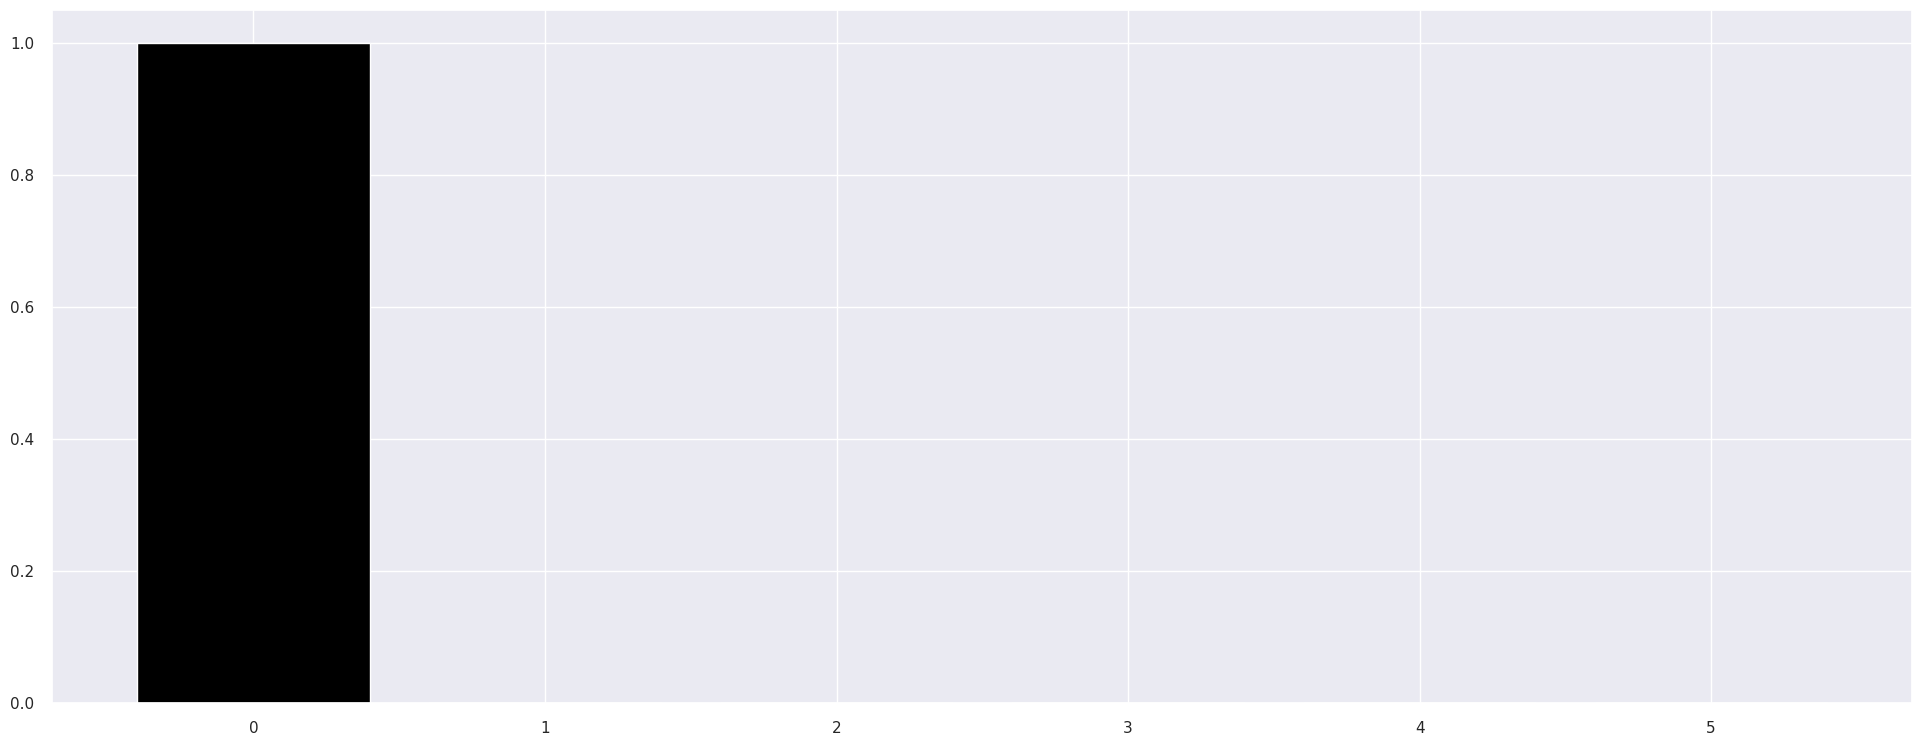

In [40]:
pca = dd.PCA( n_components=X.shape[1] )

principal_components = pca.fit_transform( X )

# plot explaned variable
features = range( pca.n_components_ )

plt.bar( features, pca.explained_variance_ratio_, color='black' )

# pca component
df_pca = pd.DataFrame( principal_components )

<Axes: xlabel='0', ylabel='1'>

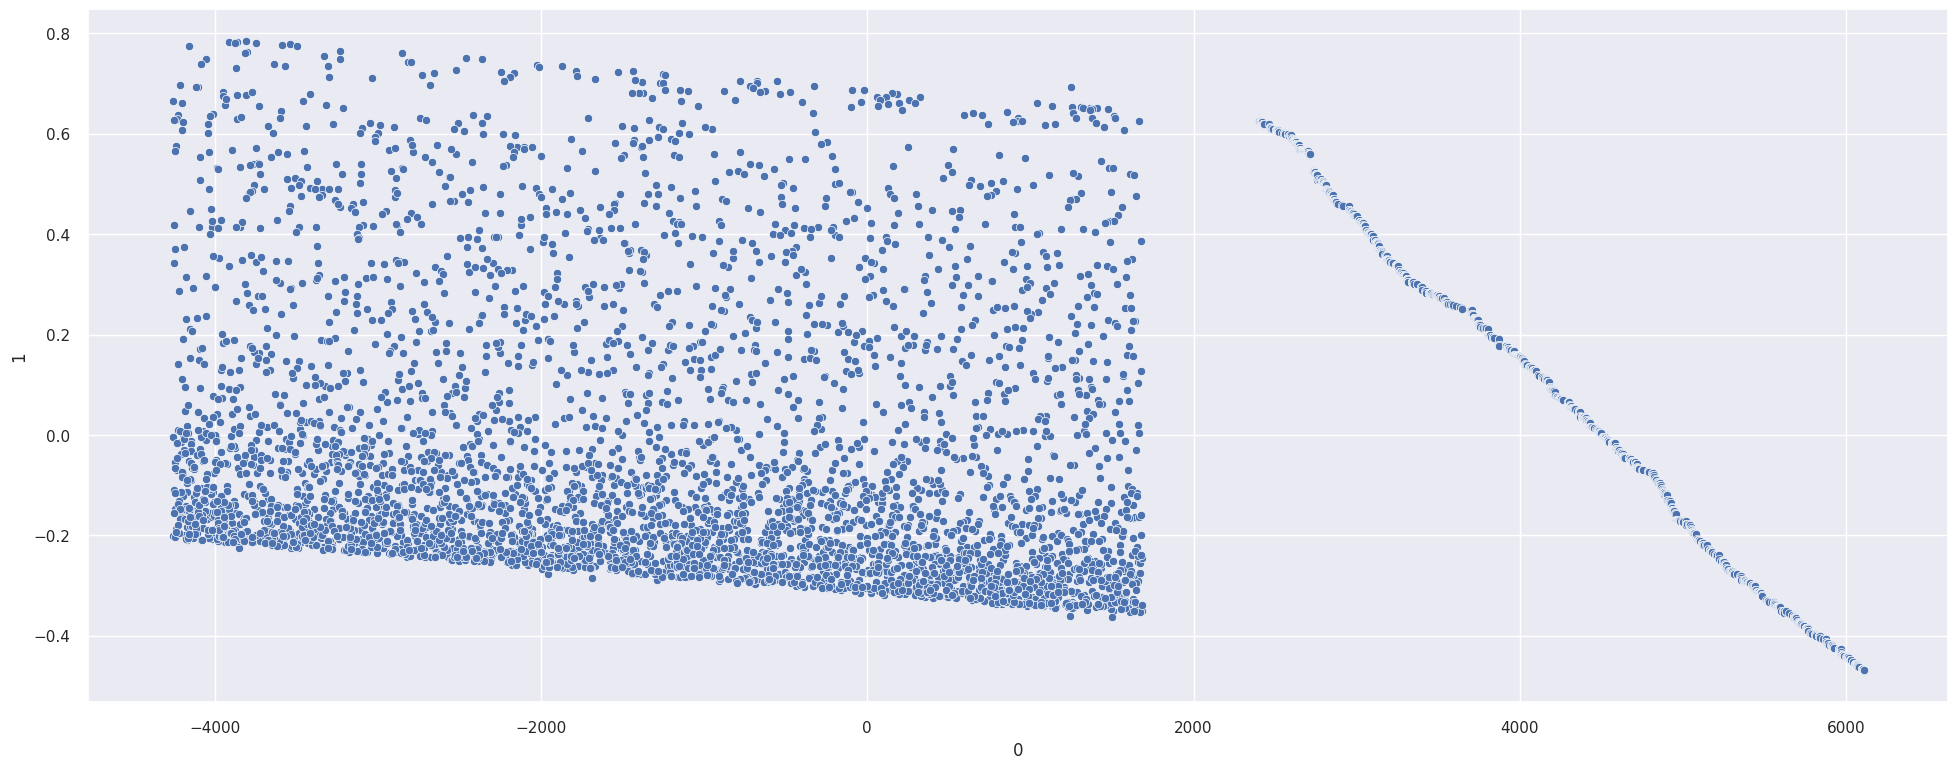

In [41]:
sns.scatterplot( x=0, y=1, data=df_pca )

### 4.3.2. UMAP

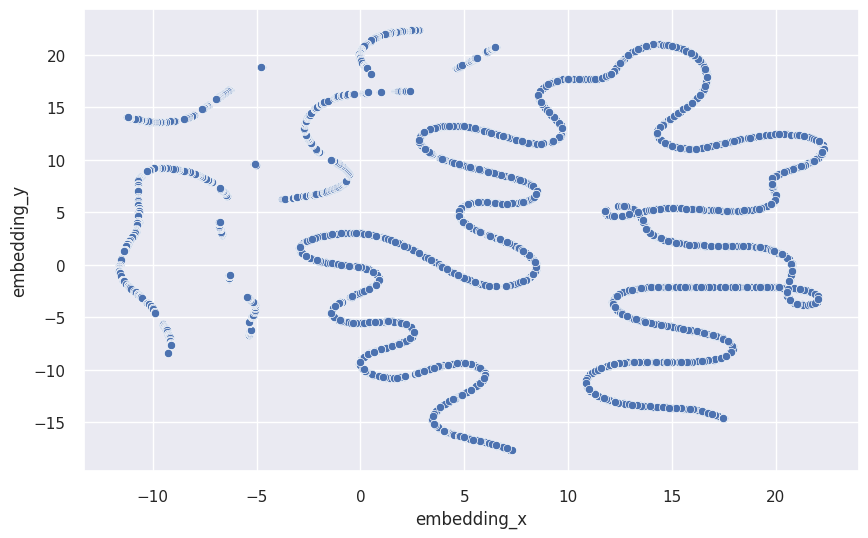

In [42]:
reducer = umap.UMAP( random_state=42 )
embedding = reducer.fit_transform( X )

# embedding
df_pca['embedding_x'] = embedding[:, 0]
df_pca['embedding_y'] = embedding[:, 1]

# plot UMAP 
plt.figure(figsize=(10, 6))
sns.scatterplot( x='embedding_x', y='embedding_y', 
                 data=df_pca )
plt.show()

### 4.3.2. t-SNE

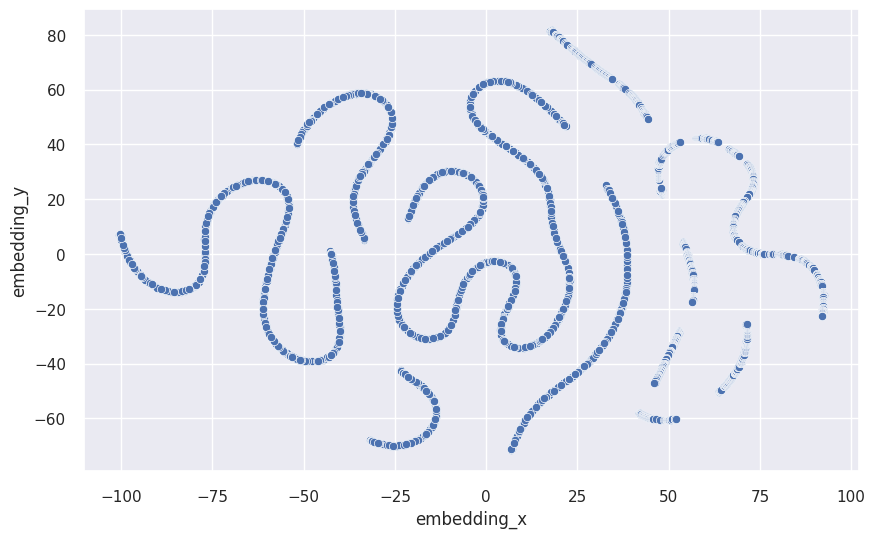

In [43]:
reducer = TSNE( n_components=2, n_jobs=-1, random_state=42 )
embedding = reducer.fit_transform( X )

# embedding
df_tsne = pd.DataFrame()
df_tsne['embedding_x'] = embedding[:, 0]
df_tsne['embedding_y'] = embedding[:, 1]

# plot UMAP 
plt.figure(figsize=(10, 6))
sns.scatterplot( x='embedding_x', y='embedding_y', 
                 data=df_tsne )
plt.show()

### 4.3.3. Tree-Based Embedding

In [74]:
# training dataset
X = df43.drop( columns=['customer_id', 'gross_revenue'], axis=1 )
y = df43['gross_revenue']

# model definition
rf_model = en.RandomForestRegressor( n_estimators=1000, random_state=42 )

# model training
rf_model.fit( X, y )


RandomForestRegressor(n_estimators=1000, random_state=42)

In [75]:
df_leaf = pd.DataFrame( rf_model.apply( X ) )

In [76]:
df_leaf.head(6)

0     1     2     3     4     5     6     7     8     9     10    11    12    13    14    15    16    17    18    19    20    21    22    23    24    25    26    27    28    29    30    31    32    33    34    35    36    37    38    39    40    41    42    43    44    45    46    47    48    49    50    51    52    53    54    55    56    57    58    59    60    61    62    63    64    65    66    67    68    69    70    71    72    73    74    75    76    77    78    79    80    81    82    83    84    85    86    87    88    89    90    91    92    93    94    95    96    97    98    99    100   101   102   103   104   105   106   107   108   109   110   111   112   113   114   115   116   117   118   119   120   121   122   123   124   125   126   127   128   129   130   131   132   133   134   135   136   137   138   139   140   141   142   143   144   145   146   147   148   149   150   151   152   153   154   155   156   157   158   159   160   161   162   163   164   165   166   167   168   169   170   171   172   173   174   175   176   177   178   179   180   181   182   183   184   185   186   187   188   189   190   191   192   193   194   195   196   197   198   199   200   201   202   203   204   205   206   207   208   209   210   211   212   213   214   215   216   217   218   219   220   221   222   223   224   225   226   227   228   229   230   231   232   233   234   235   236   237   238   239   240   241   242   243   244   245   246   247   248   249   250   251   252   253   254   255   256   257   258   259   260   261   262   263   264   265   266   267   268   269   270   271   272   273   274   275   276   277   278   279   280   281   282   283   284   285   286   287   288   289   290   291   292   293   294   295   296   297   298   299   300   301   302   303   304   305   306   307   308   309   310   311   312   313   314   315   316   317   318   319   320   321   322   323   324   325   326   327   328   329   330   331   332   333   334   335   336   337   338   339   340   341   342   343   344   345   346   347   348   349   350   351   352   353   354   355   356   357   358   359   360   361   362   363   364   365   366   367   368   369   370   371   372   373   374   375   376   377   378   379   380   381   382   383   384   385   386   387   388   389   390   391   392   393   394   395   396   397   398   399   400   401   402   403   404   405   406   407   408   409   410   411   412   413   414   415   416   417   418   419   420   421   422   423   424   425   426   427   428   429   430   431   432   433   434   435   436   437   438   439   440   441   442   443   444   445   446   447   448   449   450   451   452   453   454   455   456   457   458   459   460   461   462   463   464   465   466   467   468   469   470   471   472   473   474   475   476   477   478   479   480   481   482   483   484   485   486   487   488   489   490   491   492   493   494   495   496   497   498   499   500   501   502   503   504   505   506   507   508   509   510   511   512   513   514   515   516   517   518   519   520   521   522   523   524   525   526   527   528   529   530   531   532   533   534   535   536   537   538   539   540   541   542   543   544   545   546   547   548   549   550   551   552   553   554   555   556   557   558   559   560   561   562   563   564   565   566   567   568   569   570   571   572   573   574   575   576   577   578   579   580   581   582   583   584   585   586   587   588   589   590   591   592   593   594   595   596   597   598   599   600   601   602   603   604   605   606   607   608   609   610   611   612   613   614   615   616   617   618   619   620   621   622   623   624   625   626   627   628   629   630   631   632   633   634   635   636   637   638   639   640   641   642   643   644   645   646   647   648   649   650   651   652   653   654   655   656   657   658   659   660   661   662   663   664   665   666 

In [47]:
from mpl_toolkits.mplot3d import Axes3D

<Axes: xlabel='embedding_x', ylabel='embedding_y'>

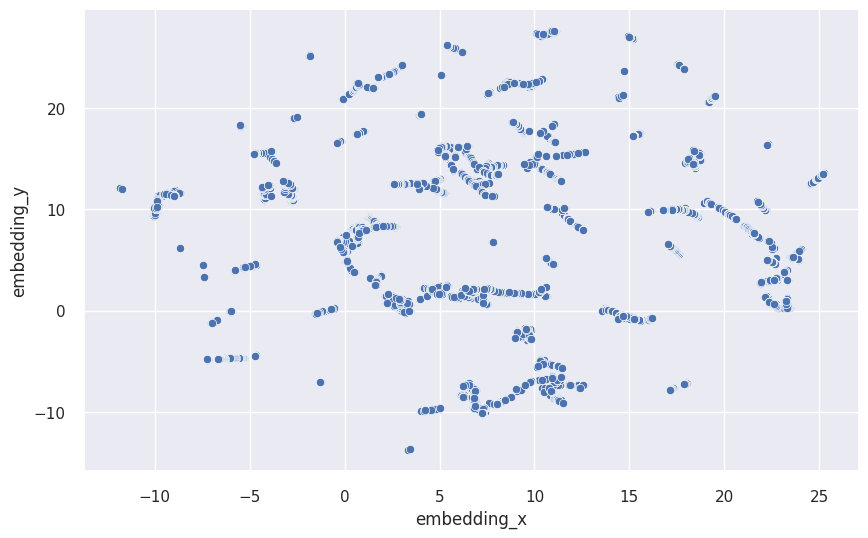

In [78]:
# reduzer dimensionality
reducer = umap.UMAP(n_components=2, random_state=42 )
embedding = reducer.fit_transform( df_leaf )

# embedding
df_tree = pd.DataFrame()
df_tree['embedding_x'] = embedding[:, 0]
df_tree['embedding_y'] = embedding[:, 1]
#df_tree['embedding_z'] = embedding[:, 2]

# plot UMAP 
plt.figure(figsize=(10, 6))
sns.scatterplot( x='embedding_x', y='embedding_y', 
                 data=df_tree )





#fig = plt.figure(figsize=(10, 8))
#ax = fig.add_subplot(projection='3d')
#
## Scatter plot tridimensional
#ax.scatter(df_tree['embedding_x'], df_tree['embedding_y'], df_tree['embedding_z'], c='b', marker='o')
#
## Rotule os eixos, se desejado
#ax.set_xlabel('Dimensão 1')
#ax.set_ylabel('Dimensão 2')
#ax.set_zlabel('Dimensão 3')
#
#plt.show()

# <div style="color:red;display:fill;border-radius:15px;background-color:#5d6d7e;letter-spacing:0.2px;overflow:hidden"><p style="padding:10px;color:white;overflow:hidden;text-align: center;margin:0;font-size:100%">5.0. Data Preparation</p></div>    

In [79]:
#df5 = df4.copy()
df5_aux = df_tree.copy()

In [50]:
#mm = pp.MinMaxScaler()
#ss = pp.StandardScaler()
#rs = pp.RobustScaler()
#
#df5['gross_revenue'] = mm.fit_transform( df5[['gross_revenue']] )
#df5['recency_days'] = mm.fit_transform( df5[['recency_days']] )
##df5['qtde_invoices'] = mm.fit_transform( df5[['qtde_invoices']] )
##df5['qtde_items'] = mm.fit_transform( df5[['qtde_items']] )
#df5['qtde_products'] = mm.fit_transform( df5[['qtde_products']] )
##df5['avg_recency_days'] = mm.fit_transform( df5[['avg_recency_days']] )
##df5['avg_ticket'] = mm.fit_transform( df5[['avg_ticket']] )
#df5['frequency'] = mm.fit_transform( df5[['frequency']] )
#df5['qtde_returns'] = mm.fit_transform( df5[['qtde_returns']] )
##df5['avg_basket_size'] = mm.fit_transform( df5[['avg_basket_size']] )
##df5['avg_unique_basket_size'] = mm.fit_transform( df5[['avg_unique_basket_size']] )

# <div style="color:red;display:fill;border-radius:15px;background-color:#5d6d7e;letter-spacing:0.2px;overflow:hidden"><p style="padding:10px;color:white;overflow:hidden;text-align: center;margin:0;font-size:100%">6.0. Feature Selection</p></div>     

In [51]:
#cols_select = ['customer_id', 'gross_revenue', 'recency_days', 'qtde_products', 'frequency', 'qtde_returns']

In [80]:
#df6 = df5[cols_select].copy()
df6 = df_tree.copy()

# <div style="color:red;display:fill;border-radius:15px;background-color:#5d6d7e;letter-spacing:0.2px;overflow:hidden"><p style="padding:10px;color:white;overflow:hidden;text-align: center;margin:0;font-size:100%">7.0. Hiperparameter Fine-Tunning</p></div>      

In [81]:
#X = df6.drop( columns=['customer_id'] )
X = df_tree.copy()

In [82]:
X.head()

embedding_x  embedding_y
0     9.100326    -7.936187
1    10.280245    -5.373515
2    10.197146    -6.888188
3    18.505709    14.952629
4    22.483515     6.664168

In [83]:
#clusters = [2, 3, 4, 5, 6, 7, 8, 9]
clusters = np.arange( 2, 26, 1)

## 7.1. K-Means

In [84]:
kmeans_list = []
for k in clusters:
    # model definition
    kmeans_model = c.KMeans( n_clusters=k )

    # model training
    kmeans_model.fit( X )

    # model predict
    labels = kmeans_model.predict( X )

    # model performance
    sil = mt.silhouette_score( X, labels, metric='euclidean' )
    kmeans_list.append( sil )

Text(0.5, 1.0, 'Silhouette Score x K')

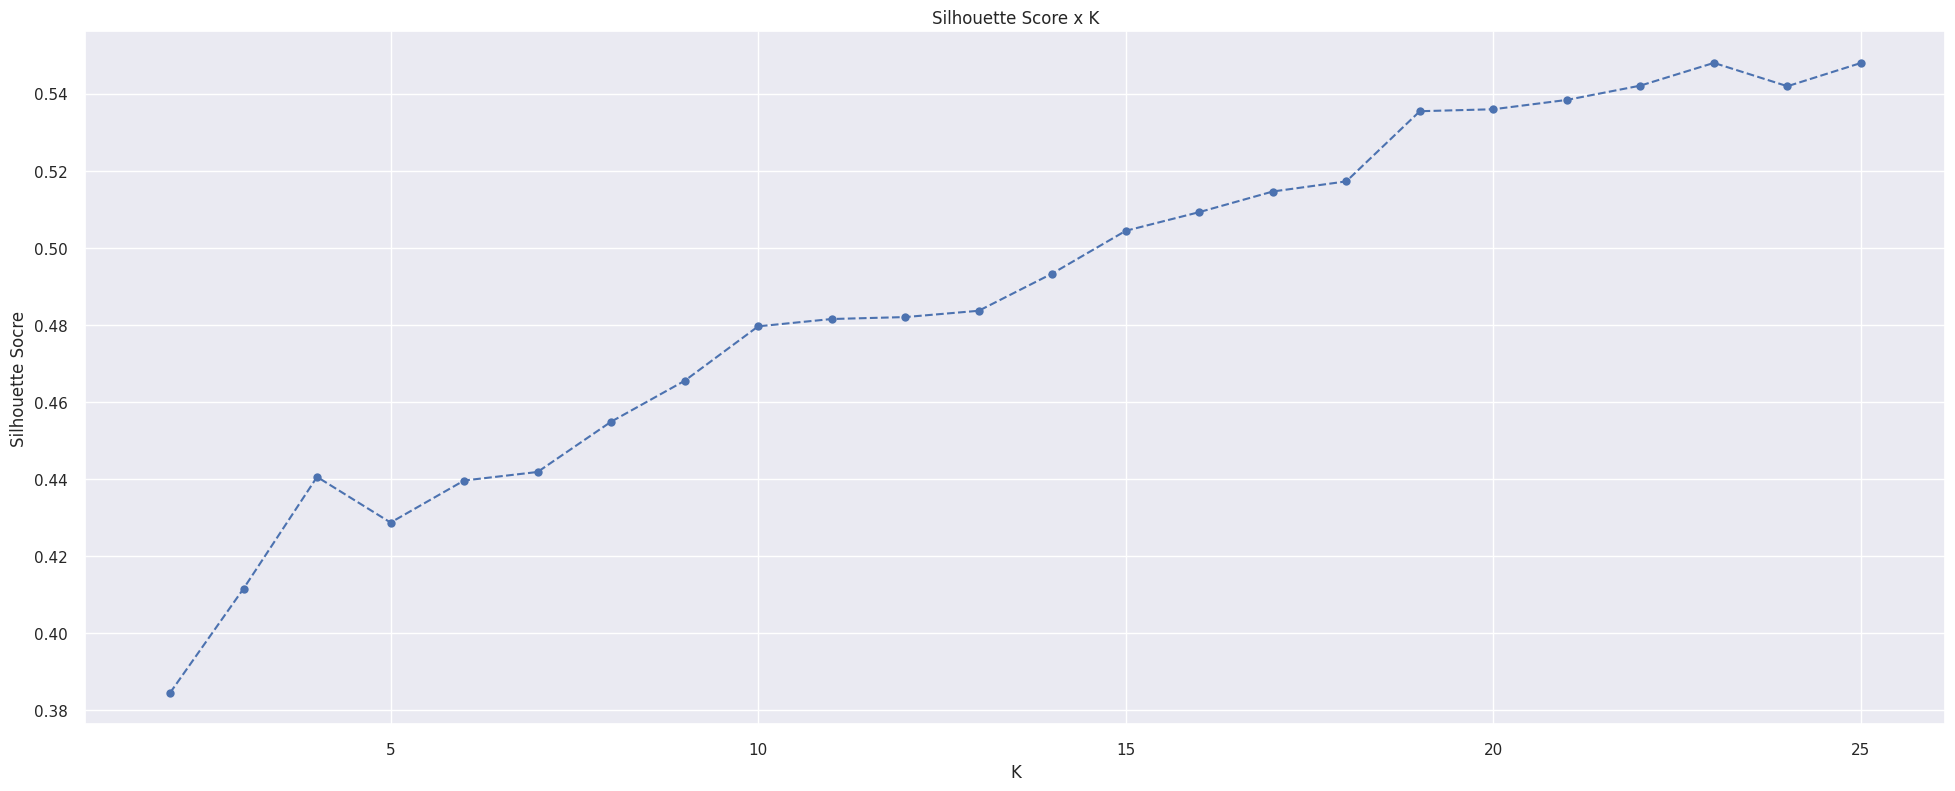

In [85]:
plt.plot( clusters, kmeans_list, linestyle='--', marker='o', color='b' )
plt.xlabel( 'K' )
plt.ylabel( 'Silhouette Socre' )
plt.title( 'Silhouette Score x K' )

## 7.2. GMM

In [86]:
gmm_list =[]
for k in clusters:
    # model definition
    gmm_model = mx.GaussianMixture( n_components=k )

    # model training
    gmm_model.fit( X )

    # model predict
    labels = gmm_model.predict( X )

    # model performance
    sil = mt.silhouette_score( X, labels, metric='euclidean' )
    gmm_list.append( sil )

Text(0.5, 1.0, 'Sil x K')

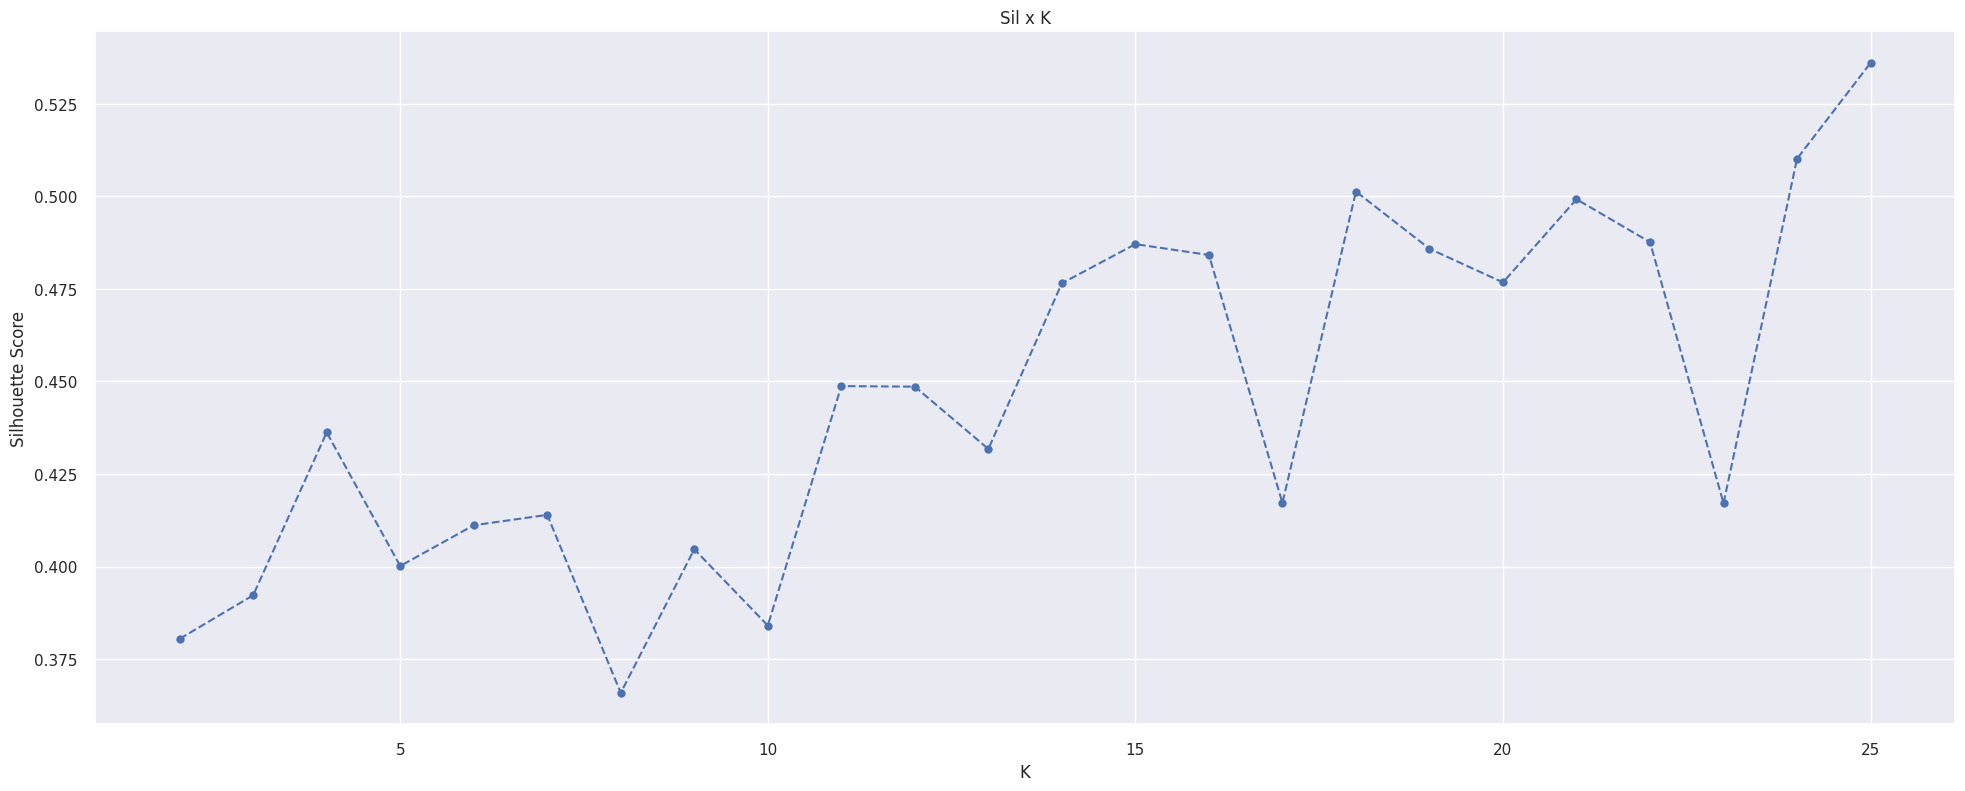

In [87]:
plt.plot( clusters, gmm_list, linestyle='--', marker='o', color='b' )
plt.xlabel( 'K' )
plt.ylabel( 'Silhouette Score' )
plt.title( 'Sil x K' )

## 7.3. Hierarchical Clustering

In [88]:
# model definition and trainig
hc_model = hc.linkage( X, 'ward' )

In [89]:
#hc.dendrogram(
#    hc_model,
#    leaf_rotation=90,
#    leaf_font_size=8
#)
#
#plt.plot()

In [90]:
#hc.dendrogram(
#    hc_model,
#    truncate_mode='lastp',
#    p=12,
#    leaf_rotation=90,
#    leaf_font_size=8,
#    show_contracted=True
#)
#
#plt.show()

### 7.3.1. HClustering Silhouette Score

In [91]:
hc_list = []
for k in clusters:
    # model definition e training
    hc_model = hc.linkage( X, 'ward' )

    # model predict
    labels = hc.fcluster( hc_model, k, criterion='maxclust' )

    # metrics
    sil = mt.silhouette_score( X, labels, metric='euclidean' )
    hc_list.append( sil )

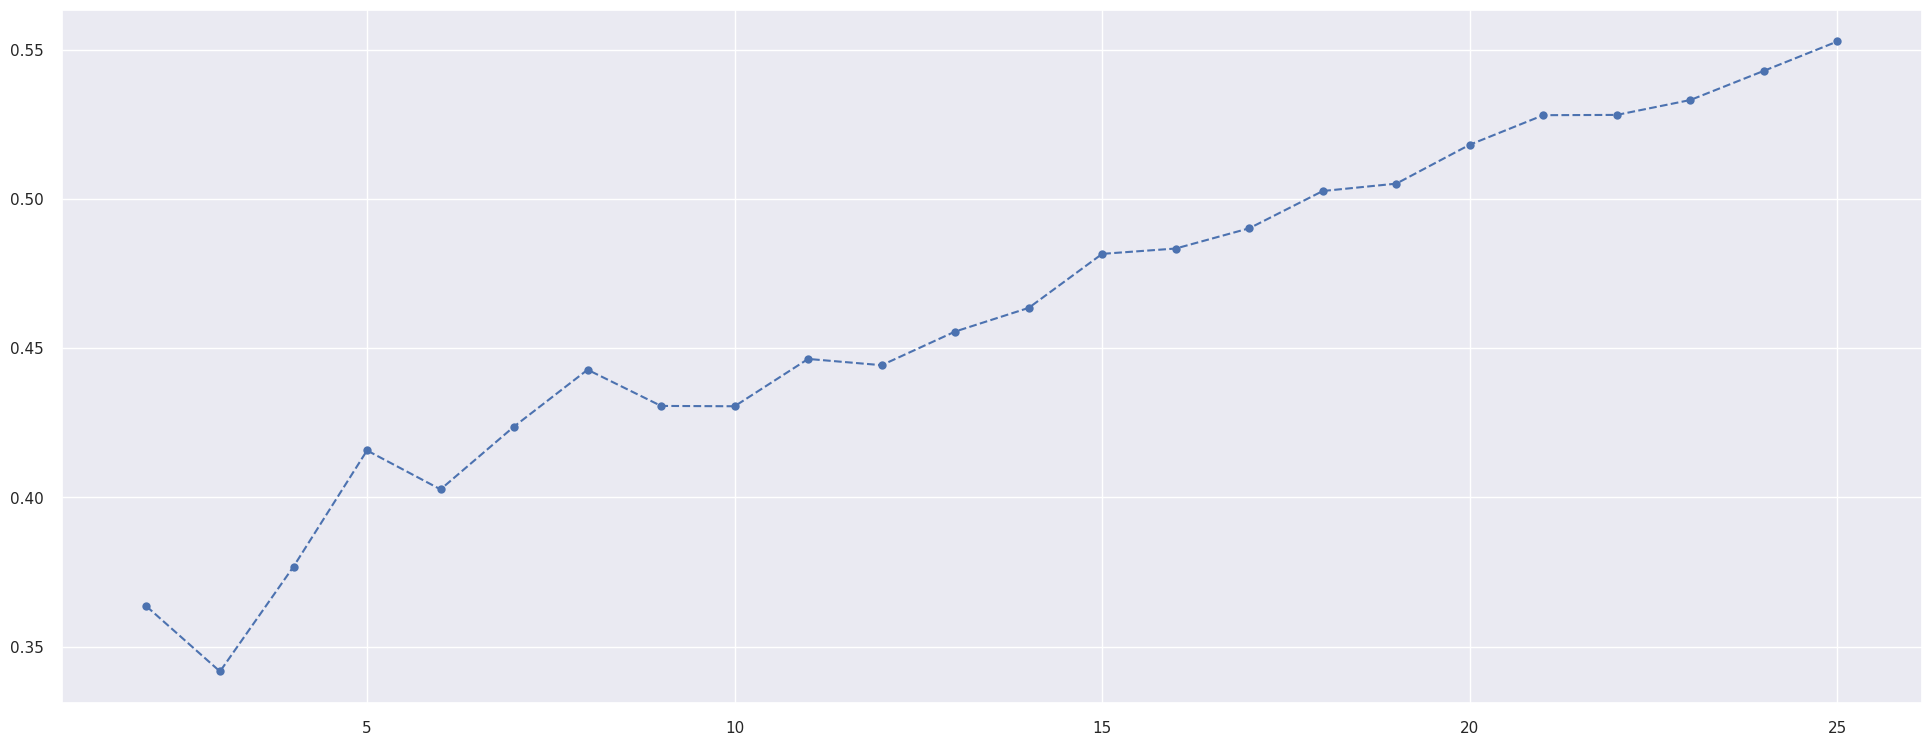

In [92]:
plt.plot( clusters, hc_list, linestyle='--', marker='o', color='b' )

## 7.4. DBSCAN

In [93]:
import optuna

In [96]:
 # Defining an objective function to be optimized
def bayesian_opt_objective(trial):
    eps = trial.suggest_float('eps', 0.5, 1.5, step=0.05)
    min_samples = trial.suggest_int('min_samples', 5, 100, step=5)

    # Defining the model
    dbscan_model = c.DBSCAN(eps=eps, min_samples=min_samples, n_jobs=-1)

    # Training the model and predicting
    labels = dbscan_model.fit_predict(X)

    # Performance
    sil = mt.silhouette_score(X, labels, metric='euclidean')

    return sil 

In [97]:
study = optuna.create_study(direction='maximize') # maximizing the precision at k
study.optimize(bayesian_opt_objective, n_trials=100); # optimizing the defined function and setting the number of trials
trial = study.best_trial

print(f'Best Silhouette Score = {trial.value} with K = {len(set(labels))}')
print(f'Best Hyperparameters = {trial.params}')

[I 2023-09-11 10:05:02,002] A new study created in memory with name: no-name-ca9fa7f8-ed3a-461b-8cfe-f3b3b22c04c3
[I 2023-09-11 10:05:02,794] Trial 0 finished with value: 0.4258210361003876 and parameters: {'eps': 0.55, 'min_samples': 35}. Best is trial 0 with value: 0.4258210361003876.
[I 2023-09-11 10:05:03,393] Trial 1 finished with value: 0.3700209856033325 and parameters: {'eps': 1.1, 'min_samples': 45}. Best is trial 0 with value: 0.4258210361003876.
[I 2023-09-11 10:05:03,966] Trial 2 finished with value: 0.5675470232963562 and parameters: {'eps': 0.9, 'min_samples': 15}. Best is trial 2 with value: 0.5675470232963562.
[I 2023-09-11 10:05:04,602] Trial 3 finished with value: 0.15893949568271637 and parameters: {'eps': 1.2000000000000002, 'min_samples': 100}. Best is trial 2 with value: 0.5675470232963562.
[I 2023-09-11 10:05:05,267] Trial 4 finished with value: -0.13055001199245453 and parameters: {'eps': 0.5, 'min_samples': 90}. Best is trial 2 with value: 0.5675470232963562.
[

Best Silhouette Score = 0.6350611448287964 with K = 25
Best Hyperparameters = {'eps': 0.5, 'min_samples': 10}


In [98]:
dbscan_list = []
for k in clusters:
    eps=0.5
    min_samples=10

    # model definition
    dbscan_model = c.DBSCAN( eps=eps, min_samples=min_samples )

    # model training and predict
    labels = dbscan_model.fit_predict( X )

    sil = mt.silhouette_score( X, labels, metric='euclidean' )
    dbscan_list.append(sil)
    #print( 'Number of Clusters: {}'.format( len( unique( labels ) ) ) )
    #print( unique(labels) )

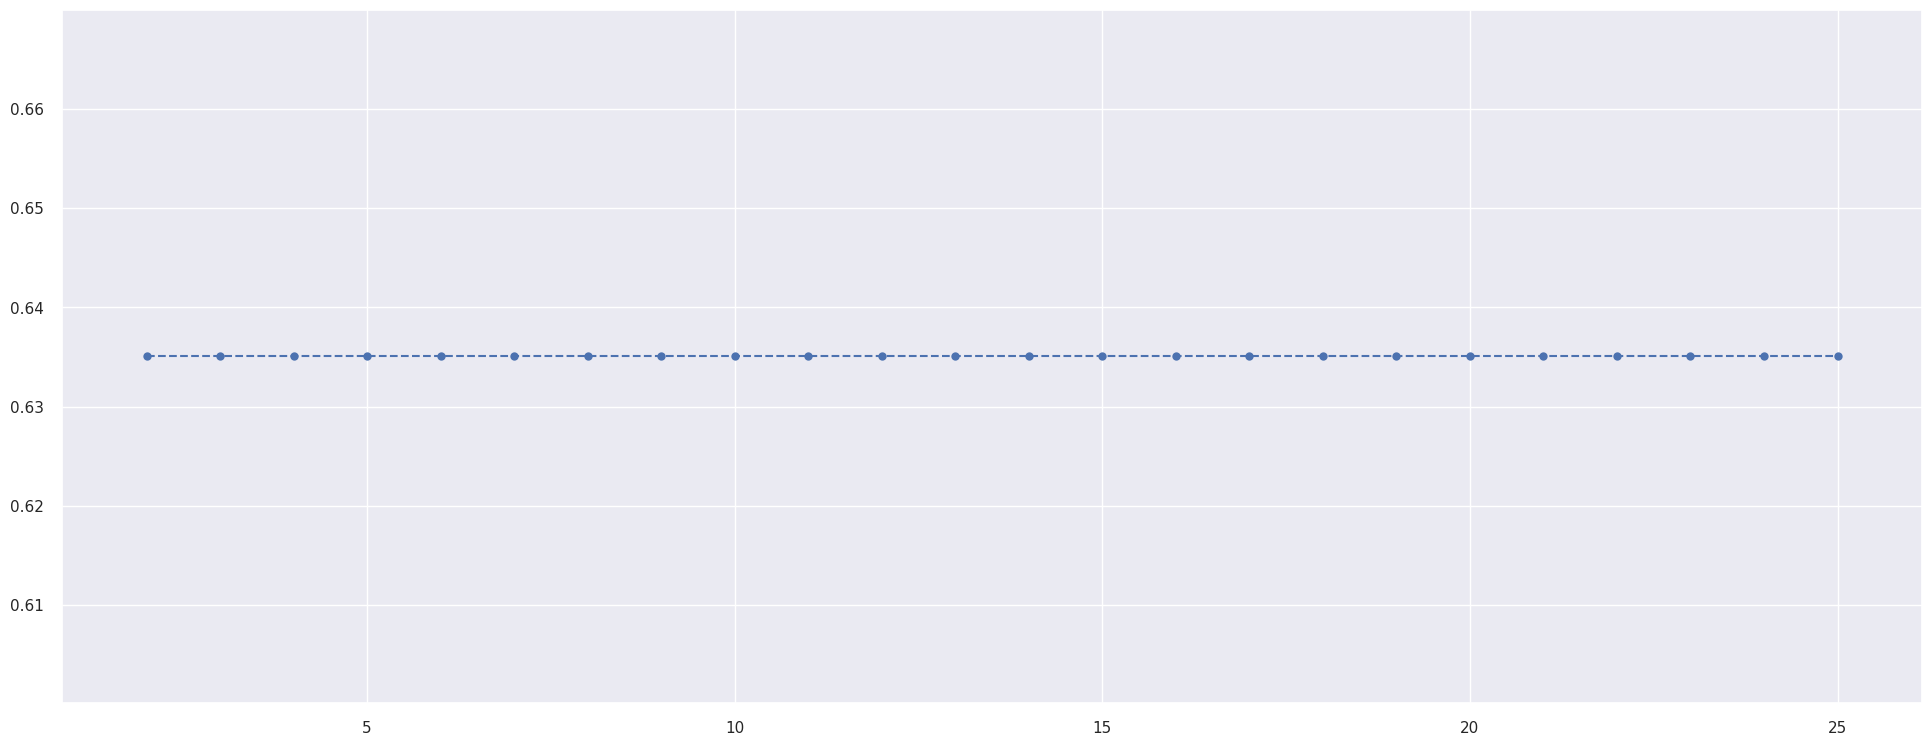

In [99]:
plt.plot( clusters, dbscan_list, linestyle='--', marker='o', color='b' )

In [80]:
neighbors = NearestNeighbors( n_neighbors=min_samples ).fit( X )
distances, indices = neighbors.kneighbors( X )

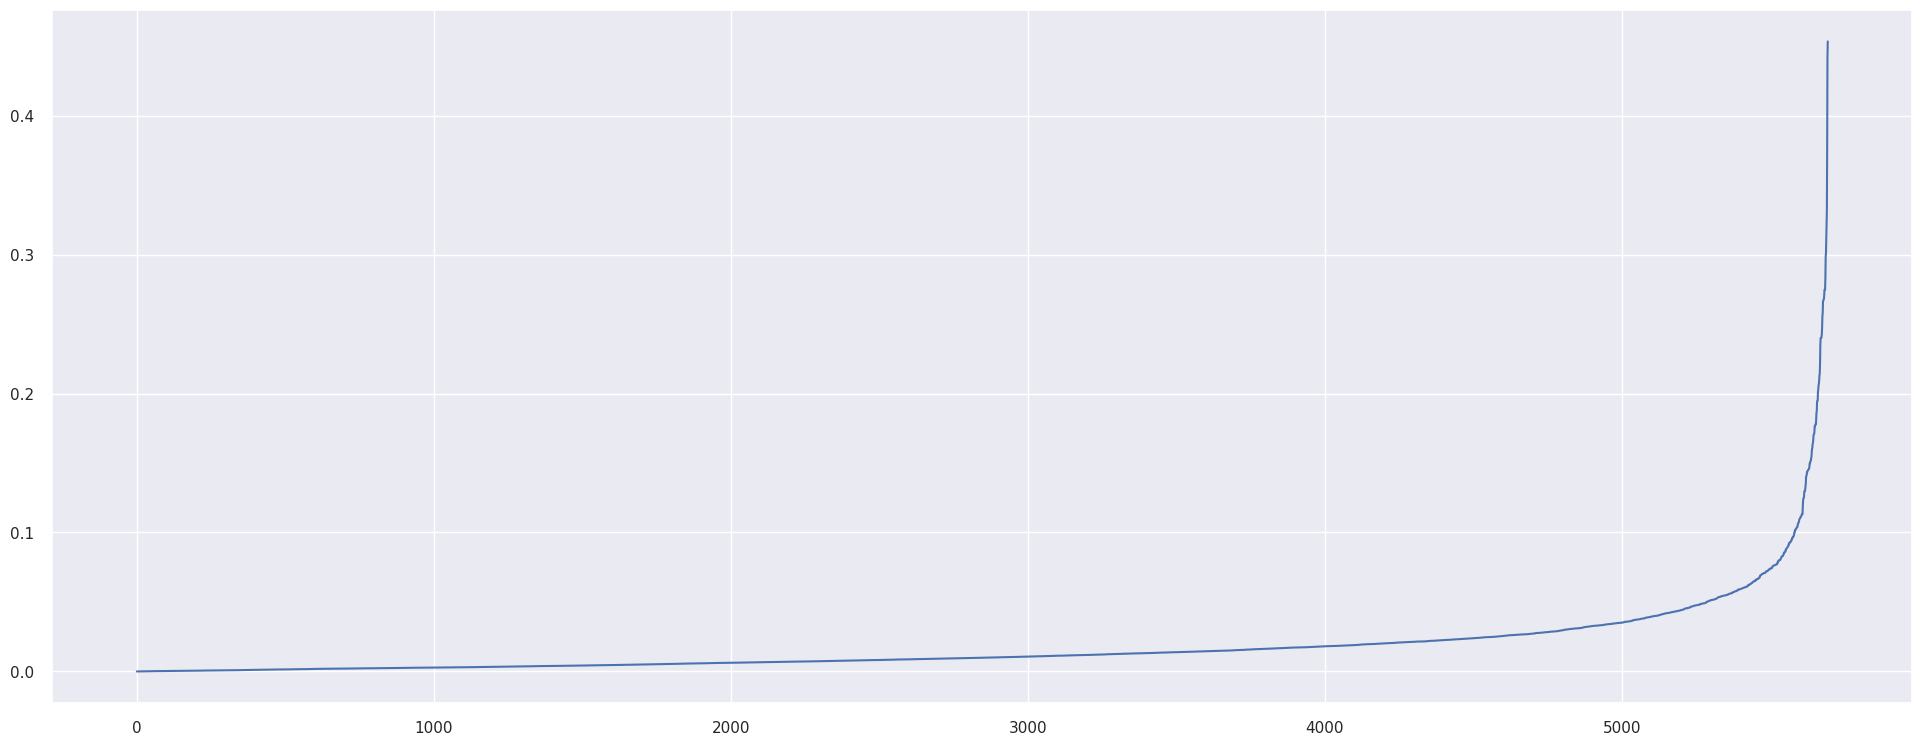

In [81]:
distances = np.sort( distances, axis=0 )
distances = distances[:, 1]
plt.plot( distances )

## 7.5. Results

In [69]:
df_results = pd.DataFrame( 
    {'kMeans': kmeans_list,
     'GMM': gmm_list,
     'HC': hc_list,
     'DBSCAN': dbscan_list}
     ).T
df_results.columns = clusters

In [70]:
df_results.style.highlight_max( color='lightgreen', axis=1 )

For K = 2. Silhouette Score: 0.4062511622905731
For K = 3. Silhouette Score: 0.479255735874176
For K = 4. Silhouette Score: 0.5325373411178589
For K = 5. Silhouette Score: 0.5293877720832825
For K = 6. Silhouette Score: 0.5514118075370789
For K = 7. Silhouette Score: 0.6119778752326965


IndexError: index 3 is out of bounds for axis 0 with size 3

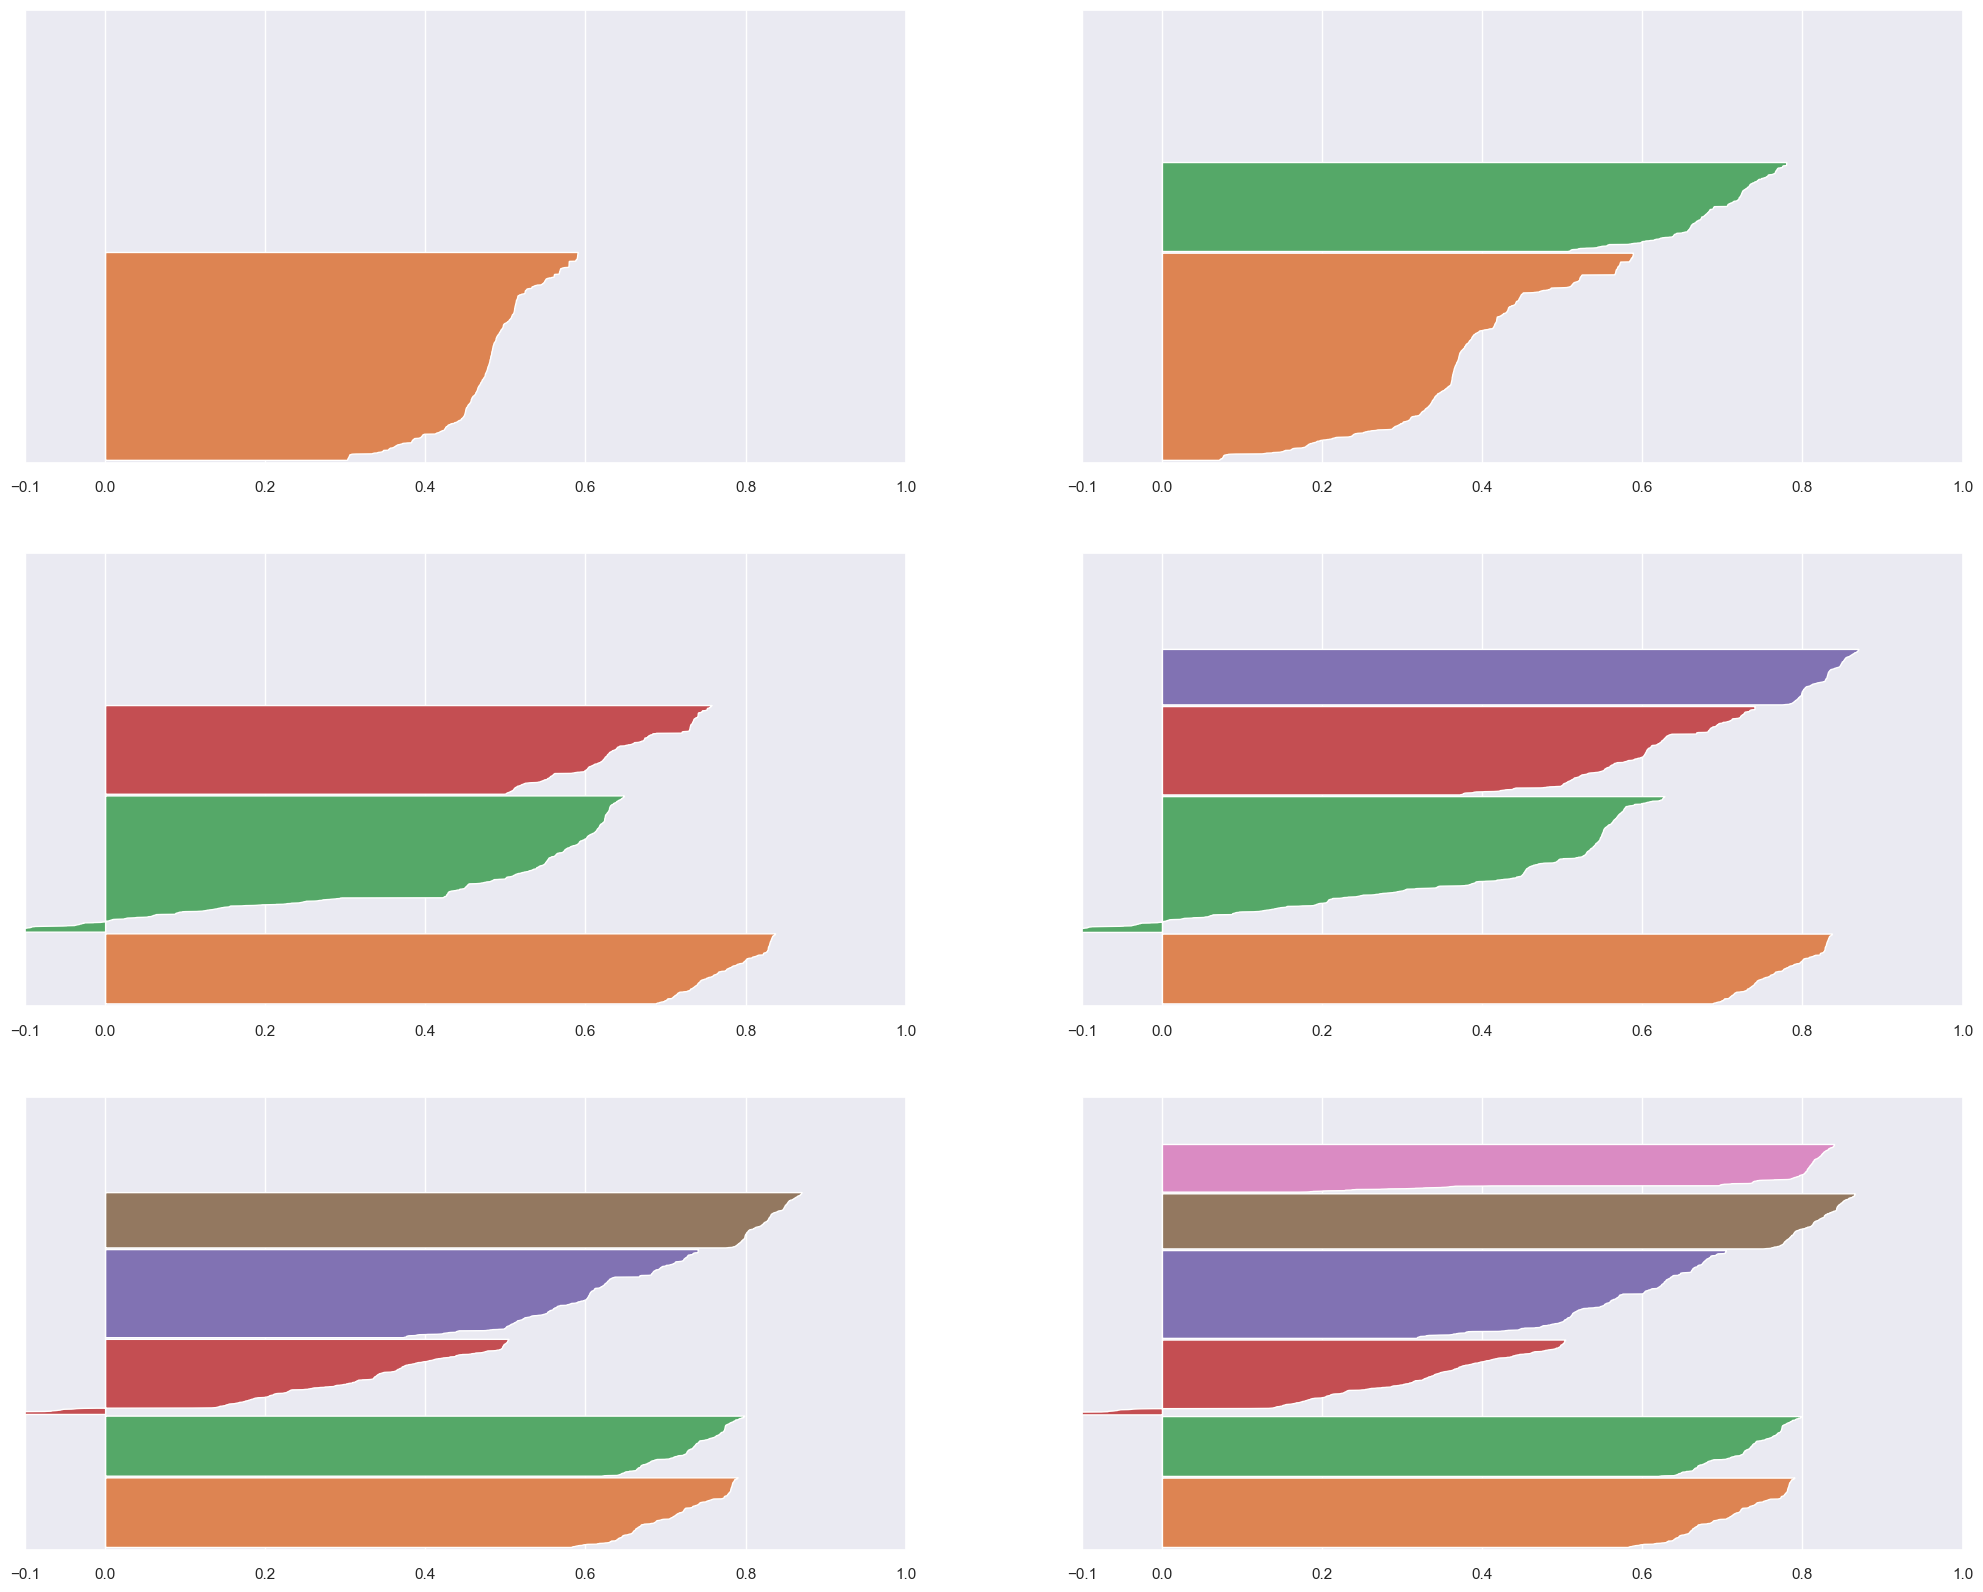

In [67]:
fig, ax = plt.subplots( 3, 2 )
fig.set_size_inches( 25, 20 )

for k in clusters:
    q, mod = divmod( k, 2 )
    
    ax[q-1, mod].set_xlim( [ -0.1, 1 ] )
    ax[q-1, mod].set_ylim( [ 0, len( X ) + ( k+1 )*10] )

    # model definition & training
    hc_model = hc.linkage( X, 'ward' )

    # model predict
    labels = hc.fcluster( hc_model, k, criterion='maxclust' )

    # performance
    ss = mt.silhouette_score( X, labels, metric='euclidean' )
    print( 'For K = {}. Silhouette Score: {}'.format( k, ss ) )
    
    samples_silhouette_values = mt.silhouette_samples( X, labels )

    y_lower = 10
    for i in range( k ):

        # select clusters
        ith_samples_silhouette_values = samples_silhouette_values[ labels==i ]
        
        # sort values
        ith_samples_silhouette_values.sort()
        
        # size clusters
        size_cluster_i = ith_samples_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        cmap = cm.get_cmap( 'Spectral' )
        color = cmap( i / k )

        ax[q-1, mod].fill_betweenx( np.arange( y_lower, y_upper ), 0, ith_samples_silhouette_values )
        
        y_lower = y_upper + 10
        
    ax[q-1, mod].set_yticks([])
    ax[q-1, mod].set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

In [69]:
#kmeans = KElbowVisualizer( c.KMeans(), k=clusters, timings=False )
#kmeans.fit( X )
#kmeans.show()

In [68]:
#kmeans = KElbowVisualizer( c.KMeans(), k=clusters, metric='silhouette',  timings=False )
#kmeans.fit( X )
#kmeans.show()

## 7.1. Sillhouette Analysis

IndexError: index 4 is out of bounds for axis 0 with size 4

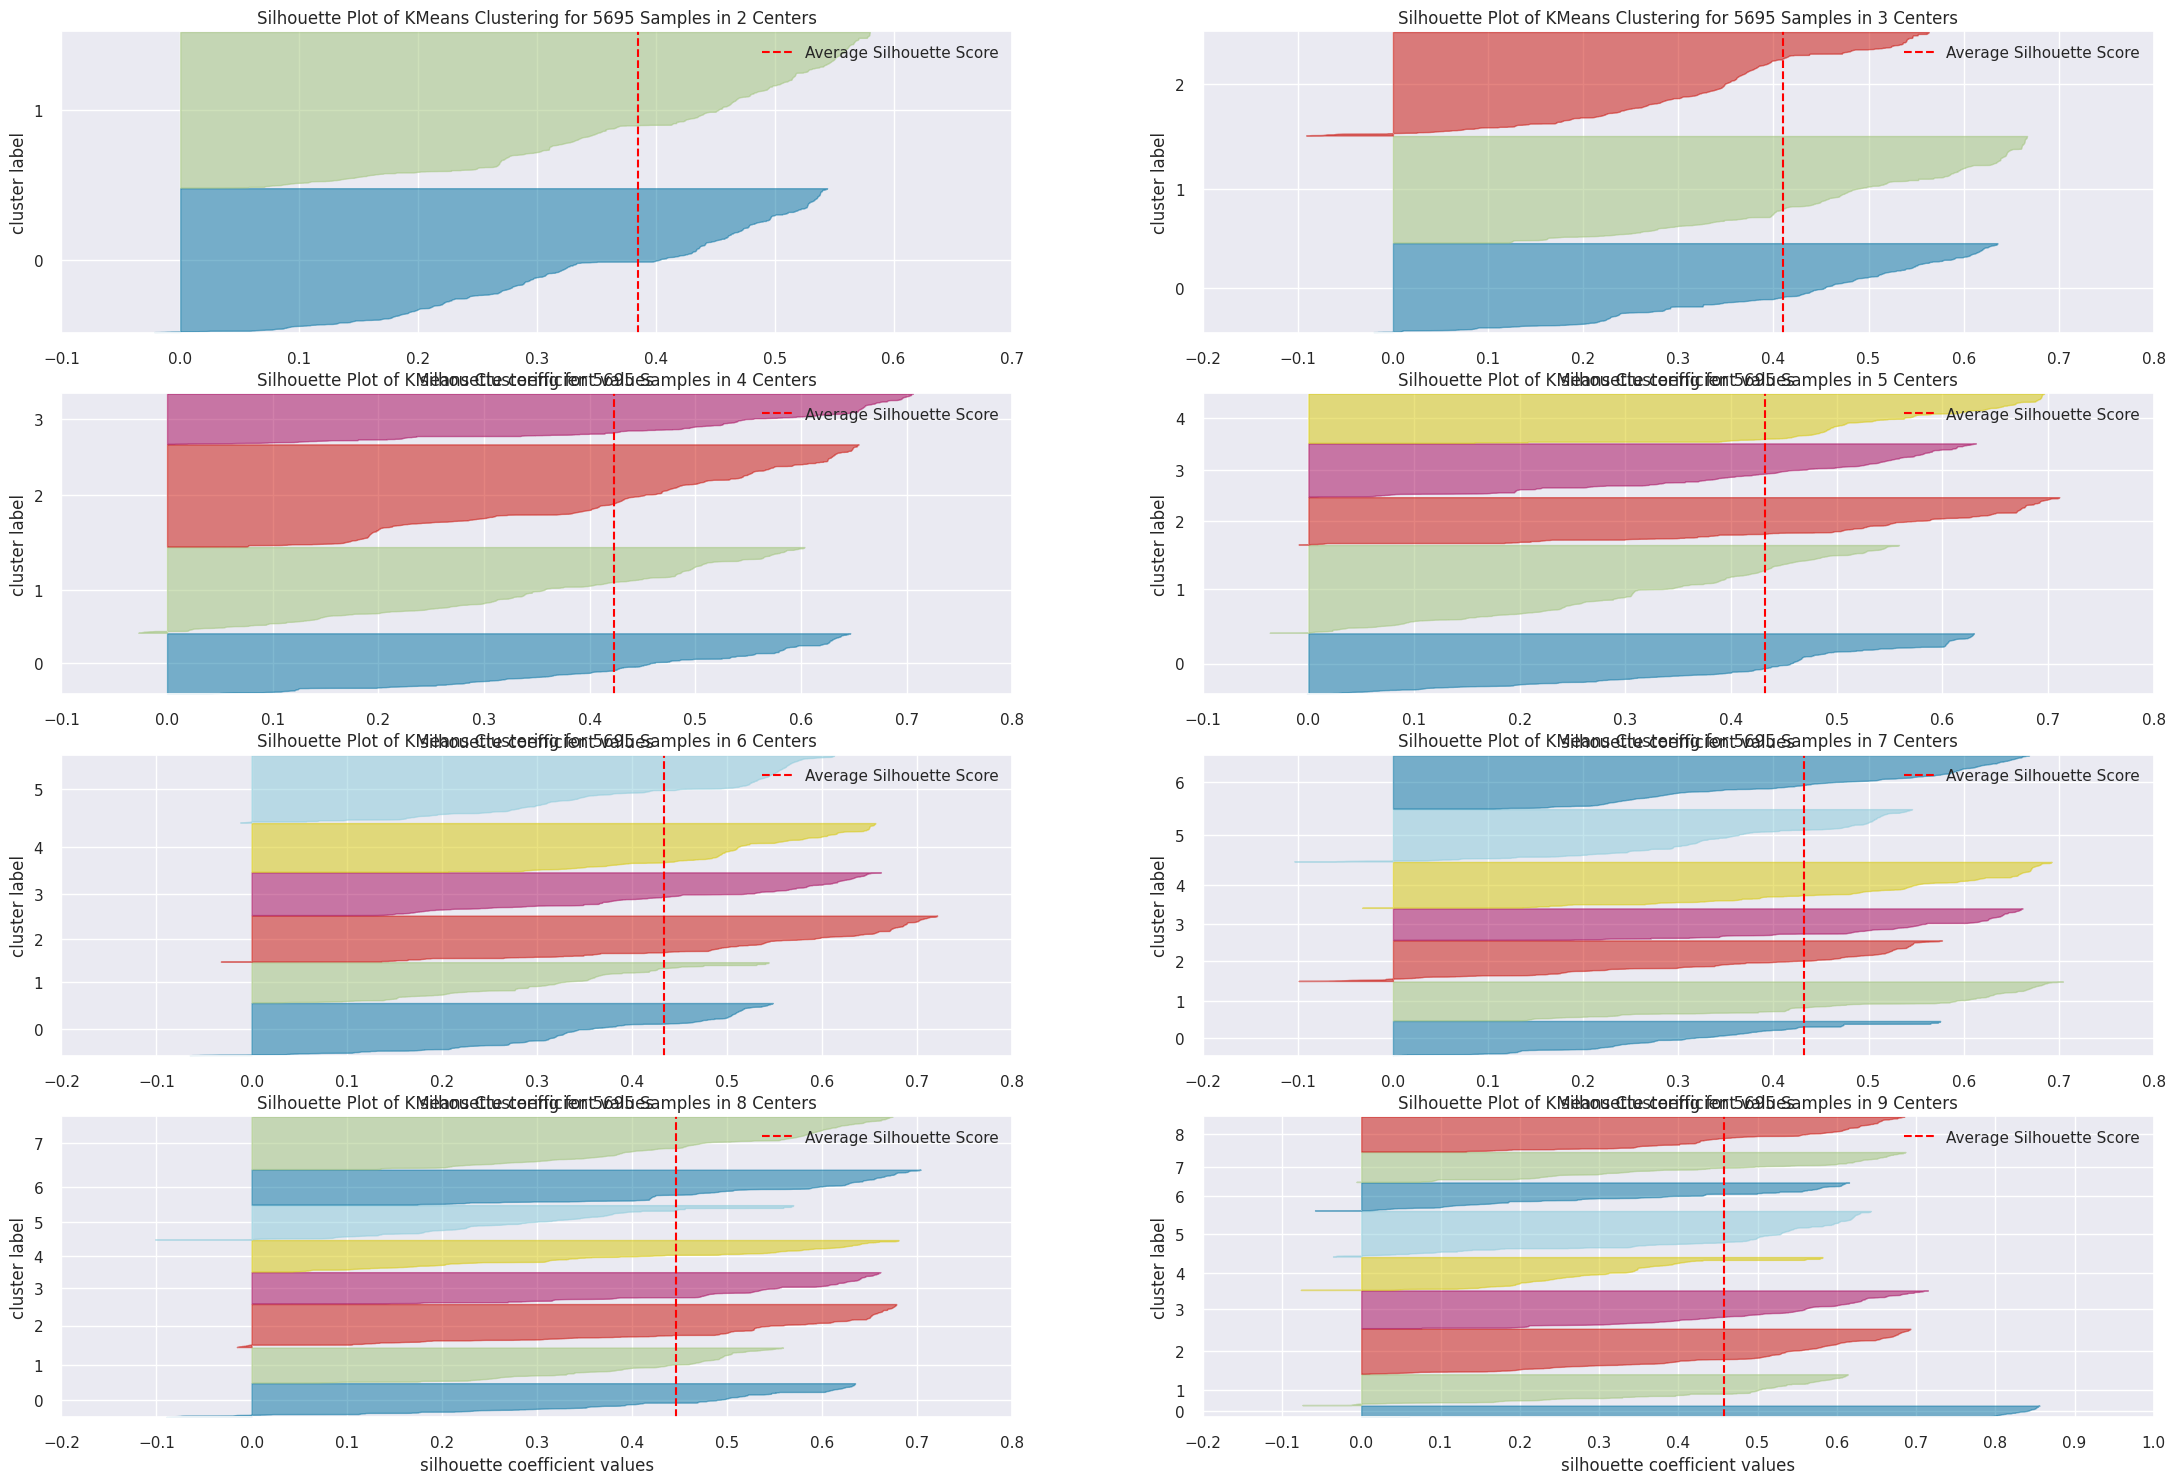

In [99]:
fig, ax = plt.subplots( 4, 2, figsize=(27, 18) )

for k in clusters:
    km = c.KMeans( n_clusters=k, init='random', n_init=10, max_iter=100, random_state=42 )
    q, mod = divmod( k, 2 )
    
    visualizer = SilhouetteVisualizer( km, colors='yellowbrick', ax=ax[q-1][mod] )
    visualizer.fit( X )
    visualizer.finalize()

# <div style="color:red;display:fill;border-radius:15px;background-color:#5d6d7e;letter-spacing:0.2px;overflow:hidden"><p style="padding:10px;color:white;overflow:hidden;text-align: center;margin:0;font-size:100%">8.0. Model Training</p></div>       

## 8.1. K-Means

In [105]:
# model definition
k = 8
kmeans = c.KMeans( init='random', n_clusters=k, n_init=10, max_iter=300, random_state=42 )

# model training
kmeans.fit( X )

# clustering 
labels = kmeans.labels_

In [94]:
#k=8
## model definition
#gmm_model = mx.GaussianMixture( n_components=k )
#
## model training
#gmm_model.fit( X )
#
## model predict
#labels = gmm_model.predict( X )

## 8.2. Cluster Validation

In [107]:
## WSS ( Within-Cluster Sum of Square )
print( 'WSS value: {}'.format(kmeans.inertia_ ) )

## SS ( Silhouette Score )
print( 'SS value: {}'.format( mt.silhouette_score( X, labels, metric='euclidean' ) ) )

WSS value: 110761.1640625


SS value: 0.4678238034248352


# <div style="color:red;display:fill;border-radius:15px;background-color:#5d6d7e;letter-spacing:0.2px;overflow:hidden"><p style="padding:10px;color:white;overflow:hidden;text-align: center;margin:0;font-size:100%">9.0. Cluster Analysis</p></div>        

In [108]:
df9 = X.copy()
df9['cluster'] = labels

In [109]:
#df92 = df4.copy()
#df9['cluster'] = labels
#df9.head()

## 9.1. Visualization Inspection

<Axes: xlabel='embedding_x', ylabel='embedding_y'>

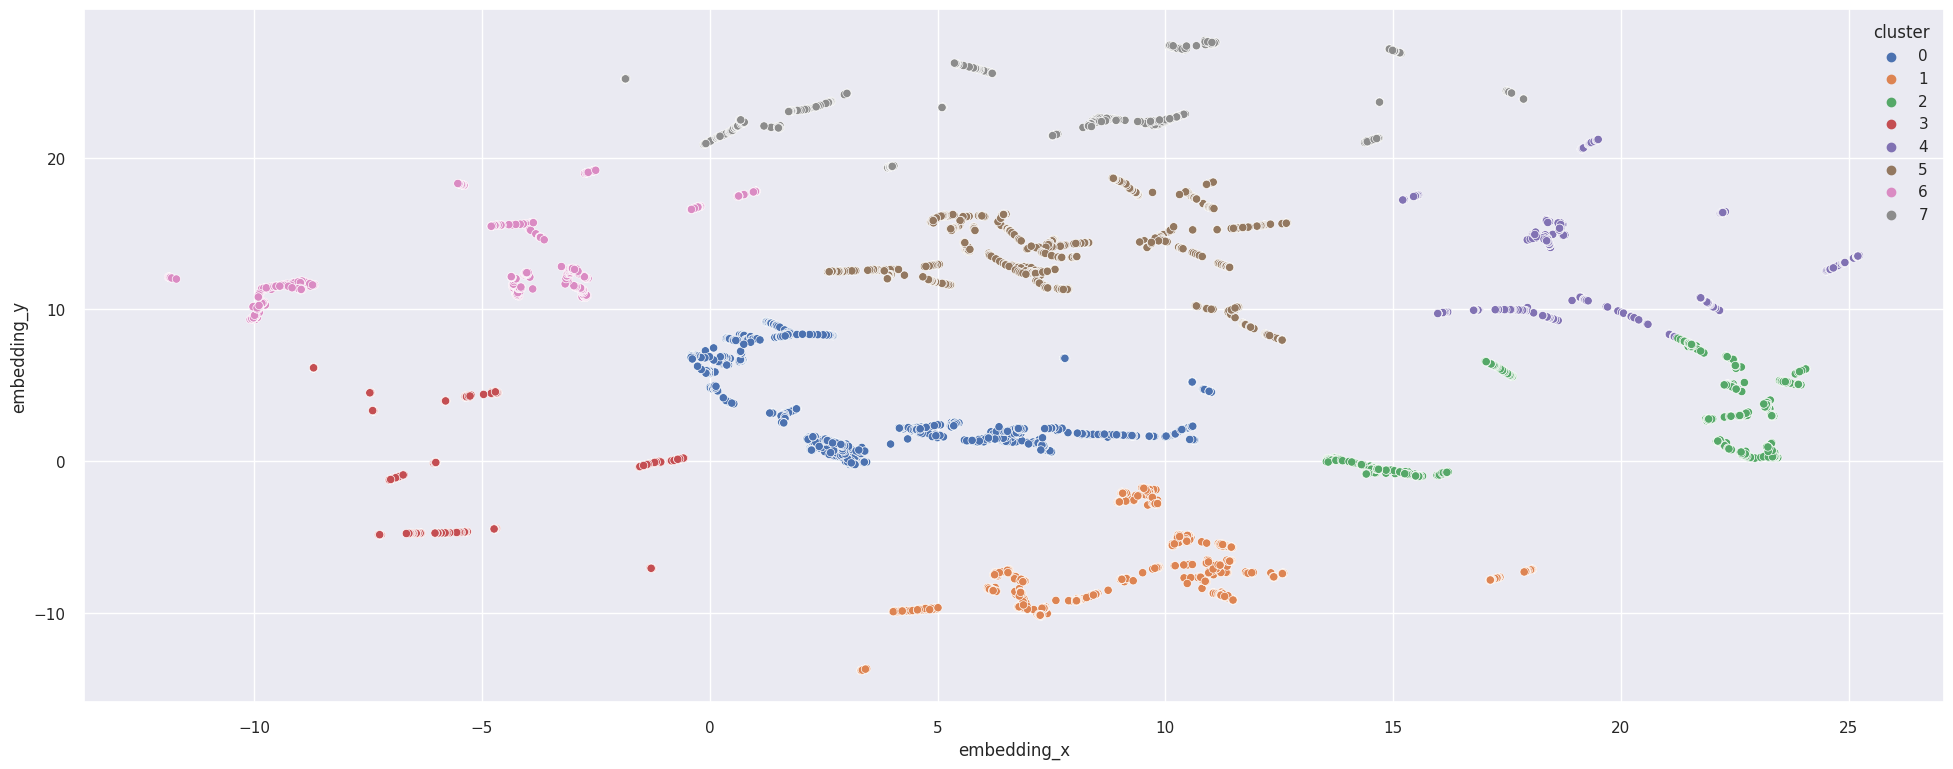

In [110]:
sns.scatterplot( x='embedding_x', y='embedding_y', data=df9, hue='cluster', palette='deep')

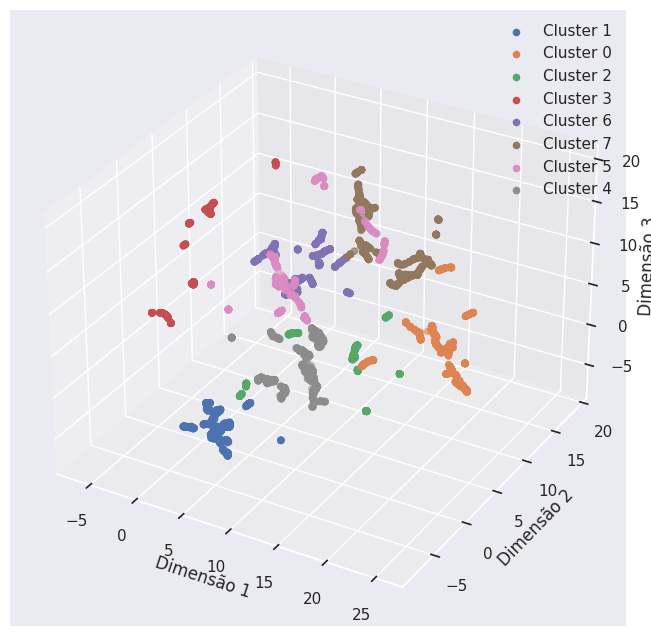

In [99]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(projection='3d')

# Iterar pelos clusters únicos e criar um gráfico de dispersão para cada cluster
for cluster_label in df9['cluster'].unique():
    cluster_data = df9[df9['cluster'] == cluster_label]
    ax.scatter(cluster_data['embedding_x'], cluster_data['embedding_y'], cluster_data['embedding_z'], label=f'Cluster {cluster_label}')

# Rotule os eixos, se desejado
ax.set_xlabel('Dimensão 1')
ax.set_ylabel('Dimensão 2')
ax.set_zlabel('Dimensão 3')

ax.legend()
plt.show()

In [100]:
#visualizer = SilhouetteVisualizer( kmeans, colors='yellowbrick' )
#visualizer.fit( X )
#visualizer.finalize()

In [101]:
#fig = px.scatter_3d( df9, x='recency_days', y='invoice_no', z='gross_revenue', color='cluster' )
#fig.show()

## 9.2. 2d plot

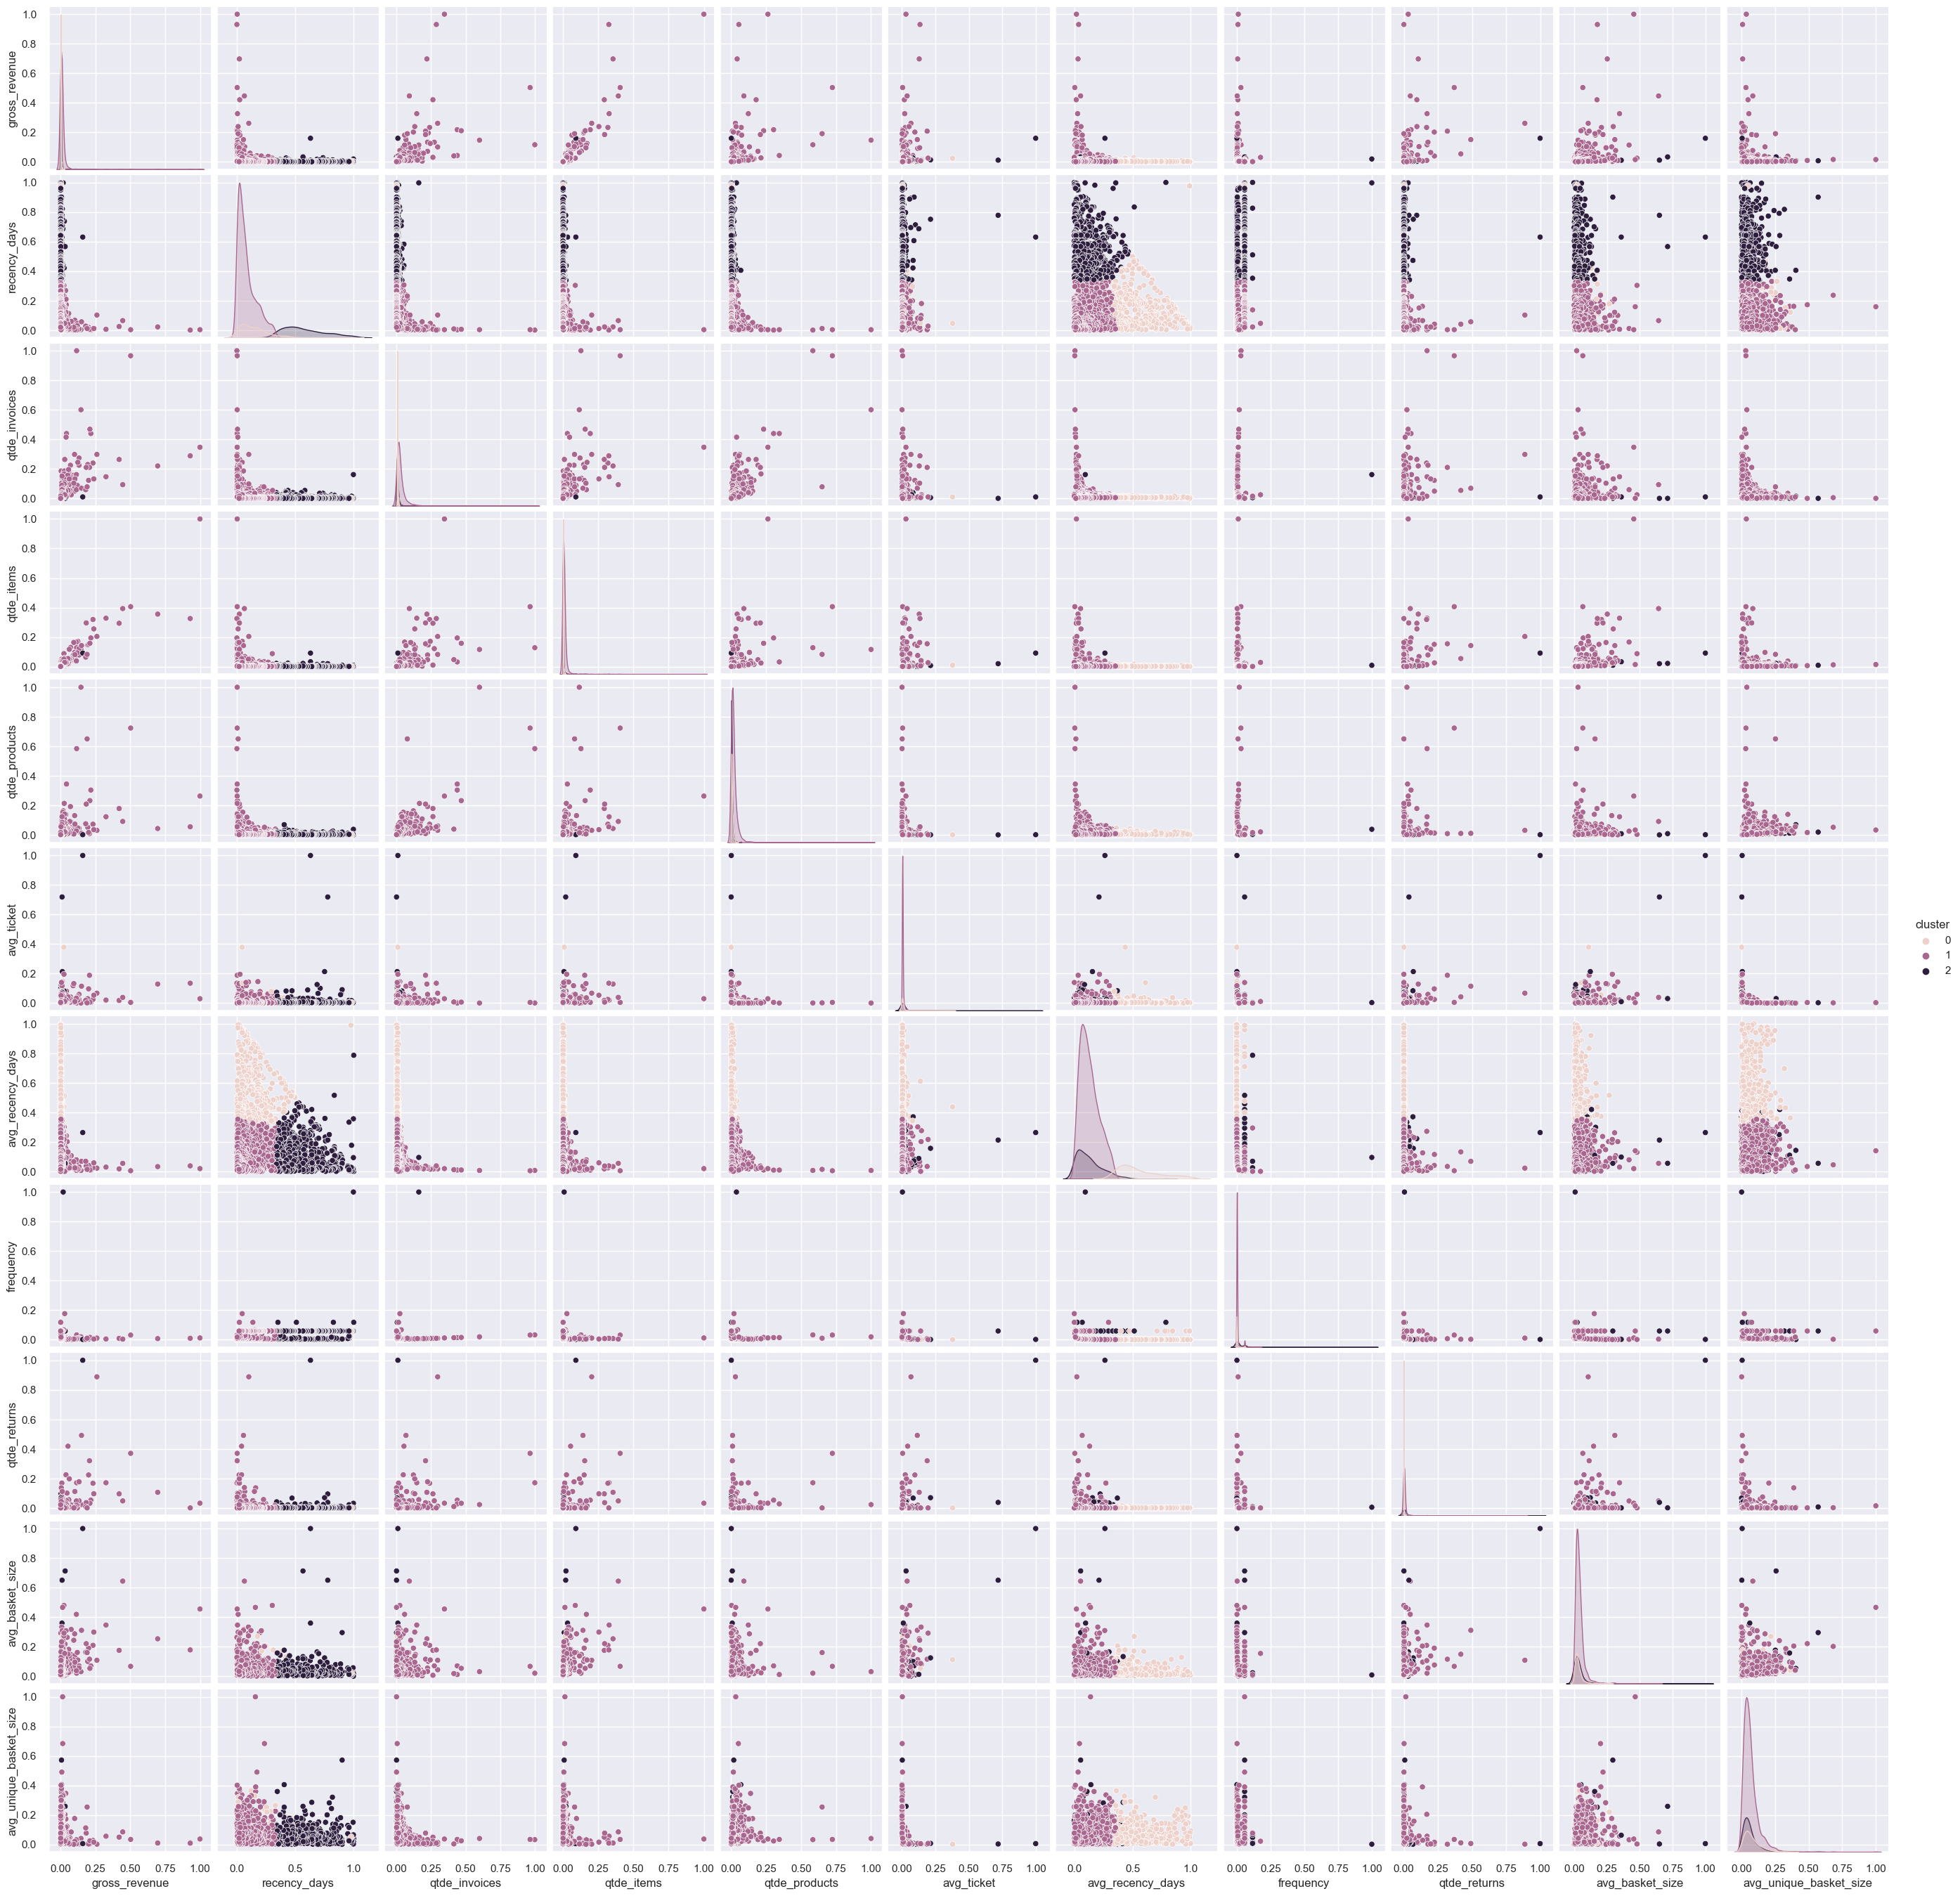

In [67]:
df_viz = df9.drop( columns='customer_id', axis=1 )
sns.pairplot( df_viz, hue='cluster')

## 9.3. UMAP 

In [111]:
#df_viz = df9.drop( columns='customer_id', axis=1 )
df_viz = df9.copy()

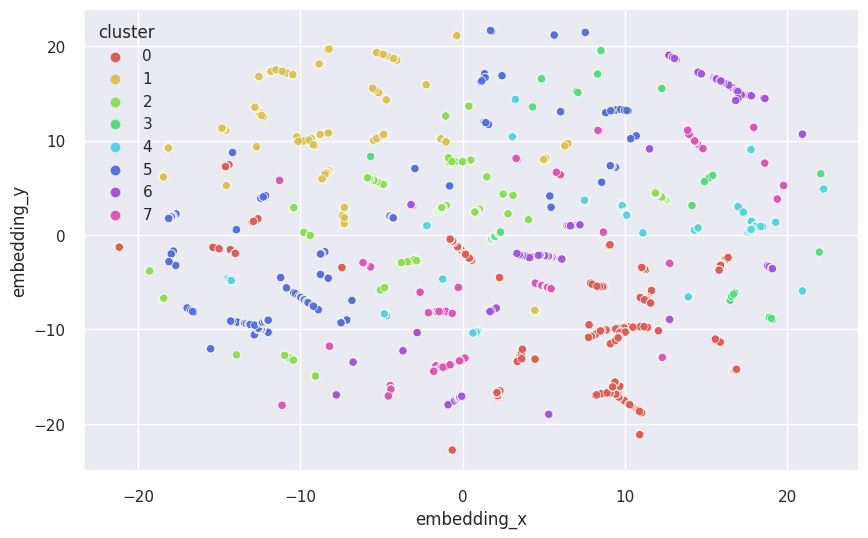

In [114]:
reducer = umap.UMAP( n_neighbors=20, random_state=42 )
embedding = reducer.fit_transform( X )

# embedding
df_viz['embedding_x'] = embedding[:, 0]
df_viz['embedding_y'] = embedding[:, 1]

# plot UMAP 
plt.figure(figsize=(10, 6))
sns.scatterplot( x='embedding_x', y='embedding_y', 
                 hue='cluster',
                 palette=sns.color_palette( 'hls', n_colors=len( df_viz['cluster'].unique() ) ),
                 data=df_viz )
plt.show()

## 9.2. Cluster Profile

In [115]:
df92 = df4[cols_selected].copy()
df92['cluster'] = labels
df92.head()

customer_id  gross_revenue  recency_days  qtde_products  frequency  qtde_returns  cluster
0        17850        5391.21         372.0          297.0  17.000000          40.0        1
1        13047        3232.59          56.0          171.0   0.028302          35.0        1
2        12583        6705.38           2.0          232.0   0.040323          50.0        1
3        13748         948.25          95.0           28.0   0.017921           0.0        4
4        15100         876.00         333.0            3.0   0.073171          22.0        2

In [116]:
# Number of customer
df_cluster = df92[['customer_id', 'cluster']].groupby( 'cluster' ).count().reset_index()
df_cluster['perc_customer'] = 100*( df_cluster['customer_id'] / df_cluster['customer_id'].sum() )

# Avg Gross revenue
df_avg_gross_revenue = df92[['gross_revenue', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge( df_cluster, df_avg_gross_revenue, how='inner', on='cluster' )

# Avg recency days
df_avg_recency_days = df92[['recency_days', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge( df_cluster, df_avg_recency_days, how='inner', on='cluster')

# Avg invoice_no
df_qtde_products = df92[['qtde_products', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge( df_cluster, df_qtde_products, how='inner', on='cluster' )

# Frequency
df_frequency = df92[['frequency', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge( df_cluster, df_frequency, how='inner', on='cluster' )

# Returns
df_qtde_returns = df92[['qtde_returns', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge( df_cluster, df_qtde_returns, how='inner', on='cluster' )

df_cluster.sort_values('gross_revenue', ascending=False)

cluster  customer_id  perc_customer  gross_revenue  recency_days  qtde_products  frequency  qtde_returns
1        1          873      15.329236    6722.649588     54.539519     325.324170   0.259396    178.696449
0        0         1125      19.754170    1547.848844    129.184889      98.466667   0.633710      2.455111
3        3          371       6.514486    1456.676280     74.113208      70.309973   0.276650     11.080863
2        2          664      11.659350     942.343810    104.596386      68.346386   0.271250      3.908133
6        6          637      11.185250     709.231083    114.519623      34.777080   0.597351      4.332810
7        7          629      11.044776     708.507472    148.189189      31.848967   0.437934      5.985692
4        4          437       7.673398     394.491350    103.945080      11.906178   0.621280      4.006865
5        5          959      16.839333     269.180396    171.457769      14.291971   1.008593      4.511992

In [ ]:
1 Cluster Insiders
4 Cluster More Products
3 Cluster Stop Returns
2 Cluster More Frequency
5 Cluster Spend Money
0 Cluster Less Days
6 Cluster Less 1k
7 Cluster More Buy

In [118]:
clusters_list = [1, 0, 3, 2, 6, 7, 4, 5]
for i in clusters_list:
    print(f""" Cluster {df_cluster['cluster'][i]}:
    -Número de Customers: {df_cluster['customer_id'][i]} ({round(df_cluster['perc_customer'][i])}%)
    -Faturamento Médio: ${round(df_cluster['gross_revenue'][i])}
    -Recencia Média: {round(df_cluster['recency_days'][i])} 
    -Média de Produtos Comprados: {round(df_cluster['qtde_products'][i])}  
    -Frequência do Produtos comprados/mês: {round((df_cluster['frequency'][i])*30 ,1)} 
    -Média de Produtos Devolvidos: {round(df_cluster['qtde_returns'][i])} """)

 Cluster 1:
    -Número de Customers: 873 (15%)
    -Faturamento Médio: $6723
    -Recencia Média: 55 
    -Média de Produtos Comprados: 325  
    -Frequência do Produtos comprados/mês: 7.8 
    -Média de Produtos Devolvidos: 179 
 Cluster 0:
    -Número de Customers: 1125 (20%)
    -Faturamento Médio: $1548
    -Recencia Média: 129 
    -Média de Produtos Comprados: 98  
    -Frequência do Produtos comprados/mês: 19.0 
    -Média de Produtos Devolvidos: 2 
 Cluster 3:
    -Número de Customers: 371 (7%)
    -Faturamento Médio: $1457
    -Recencia Média: 74 
    -Média de Produtos Comprados: 70  
    -Frequência do Produtos comprados/mês: 8.3 
    -Média de Produtos Devolvidos: 11 
 Cluster 2:
    -Número de Customers: 664 (12%)
    -Faturamento Médio: $942
    -Recencia Média: 105 
    -Média de Produtos Comprados: 68  
    -Frequência do Produtos comprados/mês: 8.1 
    -Média de Produtos Devolvidos: 4 
 Cluster 6:
    -Número de Customers: 637 (11%)
    -Faturamento Médio: $709
    -

# <div style="color:red;display:fill;border-radius:15px;background-color:#5d6d7e;letter-spacing:0.2px;overflow:hidden"><p style="padding:10px;color:white;overflow:hidden;text-align: center;margin:0;font-size:100%">10.0. Análise Exploratória de Dados</p></div>         

In [119]:
df10 = df92.copy()

In [120]:
df10.head()

customer_id  gross_revenue  recency_days  qtde_products  frequency  qtde_returns  cluster
0        17850        5391.21         372.0          297.0  17.000000          40.0        1
1        13047        3232.59          56.0          171.0   0.028302          35.0        1
2        12583        6705.38           2.0          232.0   0.040323          50.0        1
3        13748         948.25          95.0           28.0   0.017921           0.0        4
4        15100         876.00         333.0            3.0   0.073171          22.0        2

## 10.1. MindMap de hipóteses

## 10.2. Hipóteses de Negócio

In [121]:
Cluster | Variável para testar | Base de Comparação

SyntaxError: invalid syntax (2683413339.py, line 1)

### Hipótese Compra

1. Os clientes do cluster insiders usam cartão de crédito em 80% das compras.
2. Os clientes do cluster insiders possuem um ticket médio de 10% acima do cluster More Products
3. Os clientes do cluster insiders possuem um basket size acima de 5 produtos.
4. **Os clientes do cluster insiders possuem um volume (produtos) de compras acima de 10% do total de compras.**
5. **Os clientes do cluster insiders possuem um volume (faturamento) de compras acima de 10% do total de compras.**
6. **Os clientes do cluster insiders tem um número de devolução abaixo da média da base total de clientes.**
7. **A mediana do faturamento pelos clientes do cluster insiders é 10% maior do que a mediana dp faturamento geral.**
8. **O percentil do preço dos produtos comprados pelos clientes insiders.**

### H1: Os clientes do cluster insiders possuem um volume (produtos) de compras acima de 10% do total de compras.
**Verdade:** Os cluster insiders possuem um volume de compra de produtos de 49%

In [122]:
# soma da qtde de produtos do insiders
df_sales_insiders = df10.loc[df10['cluster'] == 1, 'qtde_products'].sum()
df_sales_total = df10.loc[:, 'qtde_products'].sum()

# soma da qtde de produtos total
print( '% Sales Insiders: {:.2f}%'.format( 100*df_sales_insiders/df_sales_total ) )

% Sales Insiders: 53.86%


### H2: Os clientes do cluster insiders possuem um volume (faturamento) de compras acima de 10% do total de compras.
**Verdadeiro:** O cluster insiders possuem um volume de GMV de 50%

In [123]:
# soma da qtde de produtos do insiders
df_gmv_insiders = df10.loc[df10['cluster'] == 1, 'gross_revenue'].sum()
df_gmv_total = df10.loc[:, 'gross_revenue'].sum()

# soma da qtde de produtos total
print( '% GMV Insiders: {:.2f}%'.format( 100*df_gmv_insiders/df_gmv_total ) )

% GMV Insiders: 58.08%


### H3: Os clientes do cluster insiders tem um número de devolução abaixo da média da base total de clientes.
**Falso** O cluster insiders tem média de devoluções acima da média geral

In [124]:
# média de devolução do cluster insider
df_avg_return_insiders = df10.loc[df10['cluster'] == 1, 'qtde_returns'].mean()

# média de devolução do total
df_avg_return_all = df10['qtde_returns'].mean()

print( 'Avg Return Insiders: {} vs Avg Return All: {}'.format( np.round( df_avg_return_insiders, 0 ), np.round( df_avg_return_all, 0 ) ) )

Avg Return Insiders: 179.0 vs Avg Return All: 31.0


### H4: A mediana do faturamento pelos clientes do cluster insiders é 10% maior do que a mediana dp faturamento geral.
**Verdadeiro** A média do faturamento é 493% acima da média.

In [125]:
# mediana de gmv do insiders
df_median_gmv_insiders = df10.loc[df10['cluster'] == 1, 'gross_revenue'].median()

# mediana de gmv do total
df_median_gmv_total = df10.loc[:, 'gross_revenue'].median()

gmv_diff = ( df_median_gmv_insiders - df_median_gmv_total ) / df_median_gmv_total
print( 'Median Diff: {:.2f}%'.format( 100*gmv_diff ) )

Median Diff: 427.87%


### H5: O gmv dos clientes insiders esta concentrados no 3º quartil.
**Falso** O faturamento do cluster insiders está concentrado no quartil 1

<Axes: xlabel='gross_revenue'>

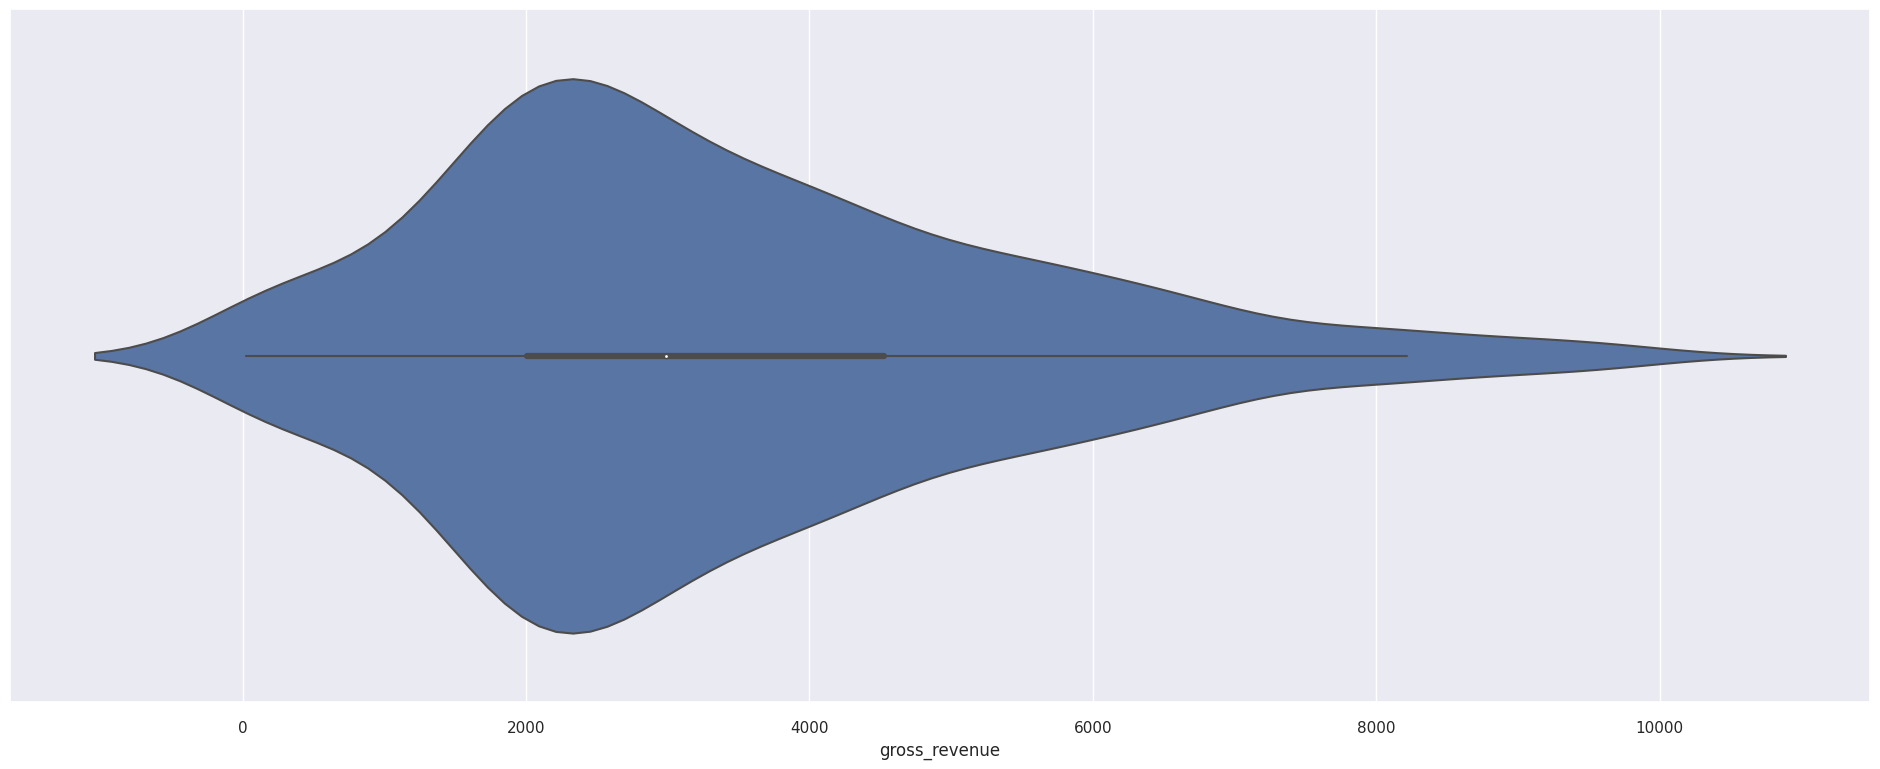

In [126]:
df_aux = df10.loc[(df10['cluster'] == 1) & (df10['gross_revenue'] < 10000 ), 'gross_revenue'];
sns.violinplot( x=df_aux ) 

### Hipótese Cliente

1. 60% dos clientes do cluster insiders possuem o estado civil de solteiro.
2. 10% dos clientes do cluster insiders estão na faixa de 24-35 anos.
3. 40% das localidades de entrega do cluster insiders estão dentro de um raio de 50km.
4. 5% dos clientes do cluster insiders recebem mais de 100 mil dólares anualmente.
5. 90% dos clientes do cluster insiders tem ensino superior completo.

### Hipótese Produto

1. 30% de todos os produtos em pacotes grandes são comprados pelos clientes do cluster insiders.
2. A mediana dos preços dos produtos comprados pelos clientes do cluster insiders é 10% maior do que a mediana de todos os preços dos produtos.
3. O percentil do preço dos produtos comprados pelos clientes insiders.
4. O peso médio dos produtos comprados pelos clientes do cluster insiders é maior do que o peso médio dos outros clusters.
5. A idade média dos produtos comprados pelos clientes do cluster insiders é menor do que 15 dias.

### Perguntas de Negócio

### 1. Quem são as pessoas elegíveis para participar do programa de Insiders?

In [128]:
df10.loc[df10['cluster'] == 1, 'customer_id'].head()

0    17850
1    13047
2    12583
5    15291
6    14688
Name: customer_id, dtype: int64

### 2. Quantos clientes farão parte do grupo?

In [129]:
df10.loc[df10['cluster'] ==1, 'customer_id'].size

873

### 3. Quais as principais características desses clientes?

#### Cluster 01: (Candidato à Insider)
    - Numero de customers: 468 (16% dos customers)
    - Faturamento médio: 8835
    - Recência média: 21 dias
    - Média de produtos comprados: 424
    - Frequência do Produtos comprados: 0.09 produtos/dia
    - Receita em média: 8835,89 dólares

### 4. Qual a porcentagem de contribuição do faturamento, vinda do Insiders?

In [130]:
df_insiders_gmv = df10.loc[df10['cluster'] == 1, 'gross_revenue'].sum()
df_all_gmv = df10.loc[:, 'gross_revenue'].sum()

print( '% GMV from Insiders: {}'.format( df_insiders_gmv / df_all_gmv ) )

% GMV from Insiders: 0.5808284349348255


### 5. Qual a expectativa de faturamento desse grupo para os próximos meses?

### 6. Quais as condições para uma pessoa ser elegível ao Insiders?

### 7. Quais as condições para uma pessoa ser removida do Insiders?

8. Qual a garantia que o programa Insiders é melhor que o restante da base?

9. Quais ações o time de marketing pode realizar para aumentar o faturamento?

## 10.3. Priorização das Hipótese

## 10.4 Validação das Hipóteses

## 10.5. Quadro de Respostas

# <div style="color:red;display:fill;border-radius:15px;background-color:#5d6d7e;letter-spacing:0.2px;overflow:hidden"><p style="padding:10px;color:white;overflow:hidden;text-align: center;margin:0;font-size:100%">11.0. Deploy to Production</p></div>         